In [ ]:
import pandas as pd # working with dataframes
import missingno #package to find and display na
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf#used for fitting models
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.metrics import roc_curve #AUC info
from sklearn.metrics import roc_auc_score# AUC score
from sklearn.metrics import accuracy_score #accuracy performance measure
from sklearn.metrics import recall_score# sensitivity performance measure
from sklearn.metrics import precision_score# precision performance measure
from sklearn.metrics import confusion_matrix# confusion matrix
from mizani.formatters import percent_format #to have % on axis in plotnine
import sys #maxsize
import seaborn as sns# heatmap
import datetime# working with dates
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
#Time frame
starttime=datetime.datetime.strptime('01/05/2022','%d/%m/%Y')
endtime=datetime.datetime.strptime('31/12/2022','%d/%m/%Y') #end of fall

#Read in dataframes
#summerfintrx = pandas.read_csv(r'C:\Users\Hp\Downloads\summerfintrx.csv',parse_dates=['Date'])
#summersesstrx = pandas.read_csv(r'C:\Users\Hp\Downloads\summersesstrx.csv',parse_dates=['Date'])
#fallfintrx = pandas.read_csv(r'C:\Users\Hp\Downloads\fallfintrx.csv',parse_dates=['Date'])
#fallsesstrx = pandas.read_csv(r'C:\Users\Hp\Downloads\fallsesstrx.csv',parse_dates=['Date'])
#customerdata = pandas.read_csv(r'C:\Users\Hp\Downloads\customerdata.csv',parse_dates=['Registrationdate'])
summerfintrx = pd.read_csv('/content/drive/My Drive/summerfintrx.csv',parse_dates=['Date'])
summersesstrx = pd.read_csv('/content/drive/My Drive/summersesstrx.csv',parse_dates=['Date'])
fallfintrx = pd.read_csv('/content/drive/My Drive/fallfintrx.csv',parse_dates=['Date'])
fallsesstrx = pd.read_csv('/content/drive/My Drive/fallsesstrx.csv',parse_dates=['Date'])
customerdata = pd.read_csv('/content/drive/My Drive/customerdata.csv',parse_dates=['Registrationdate'])




<Axes: >

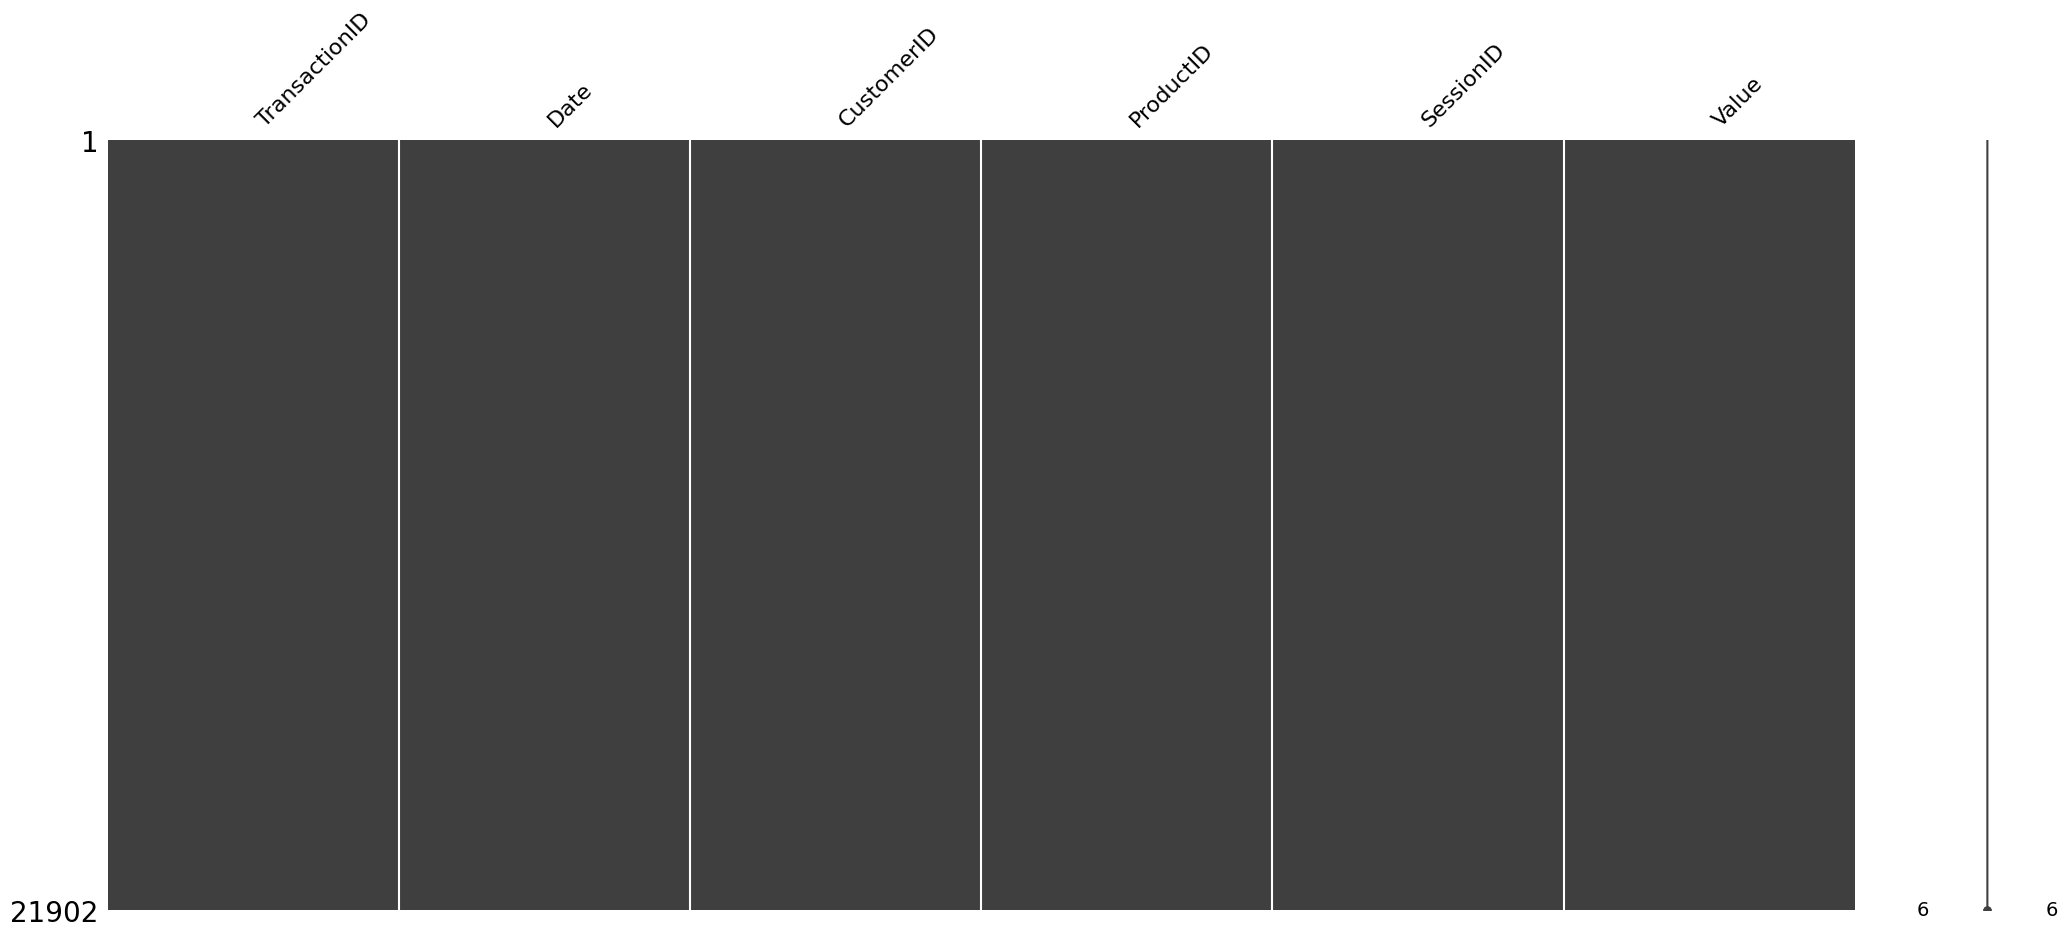

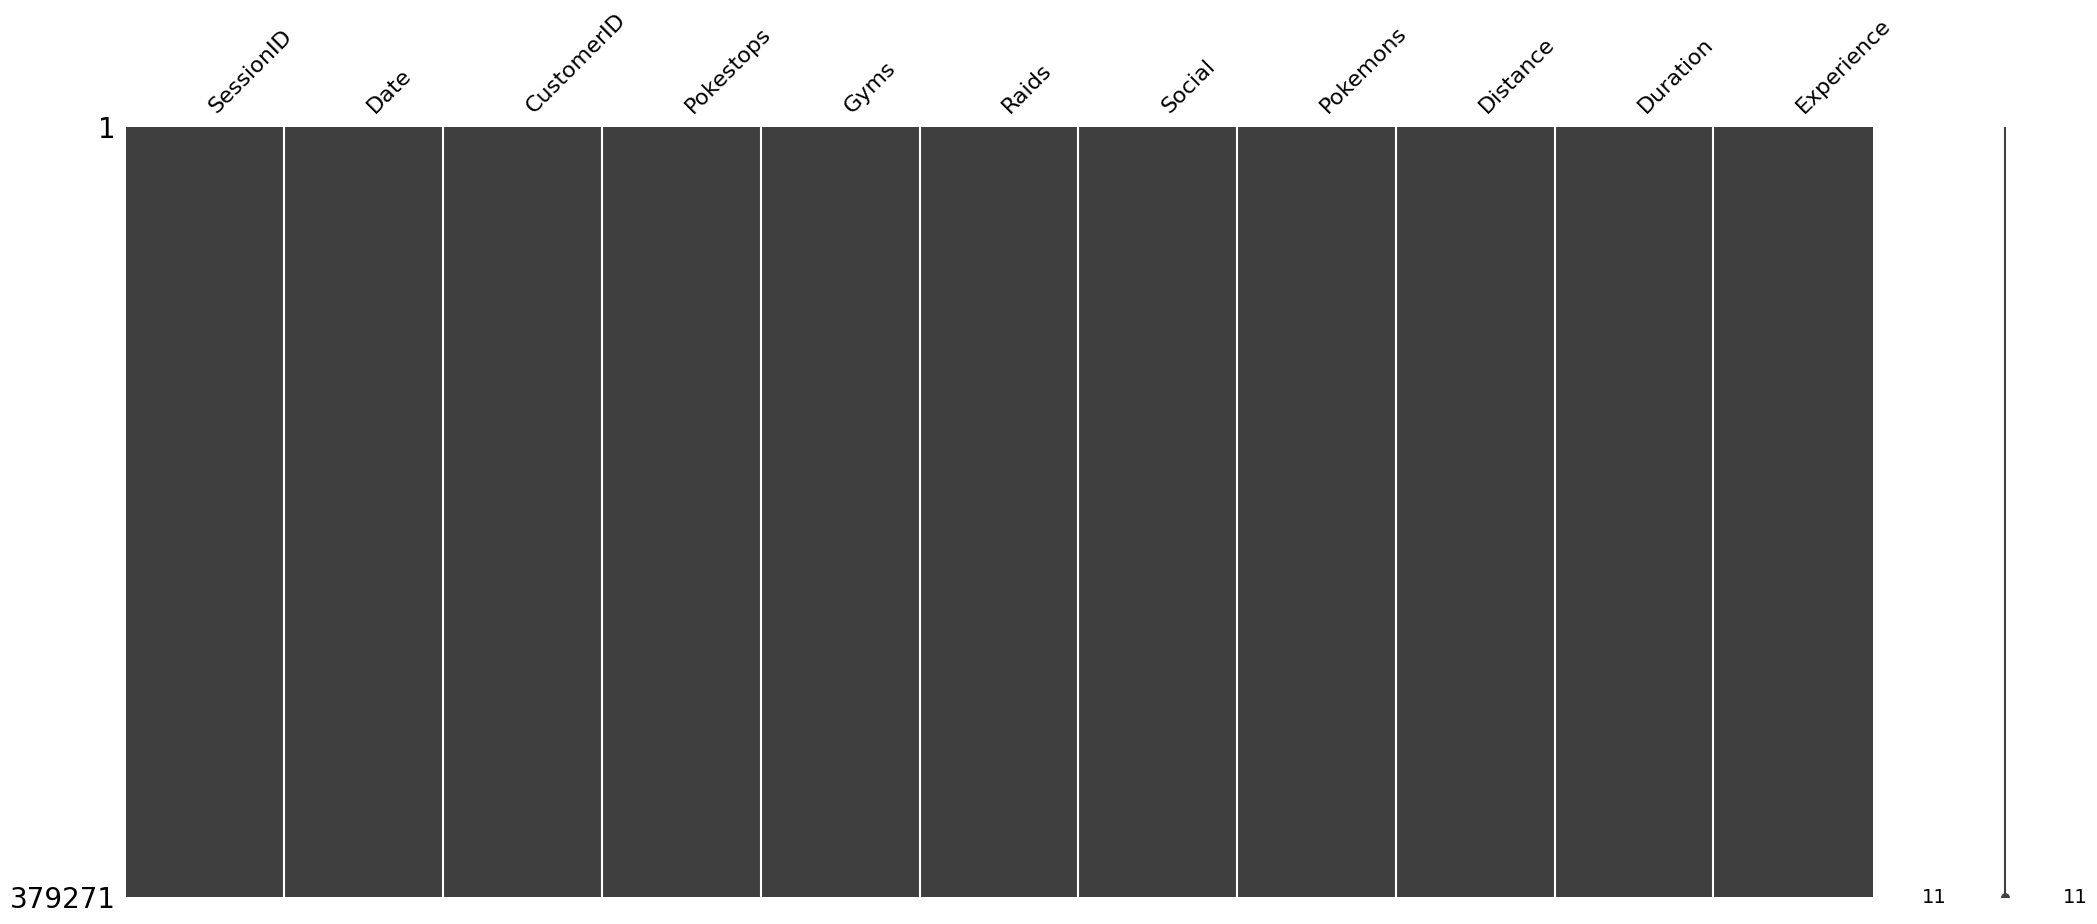

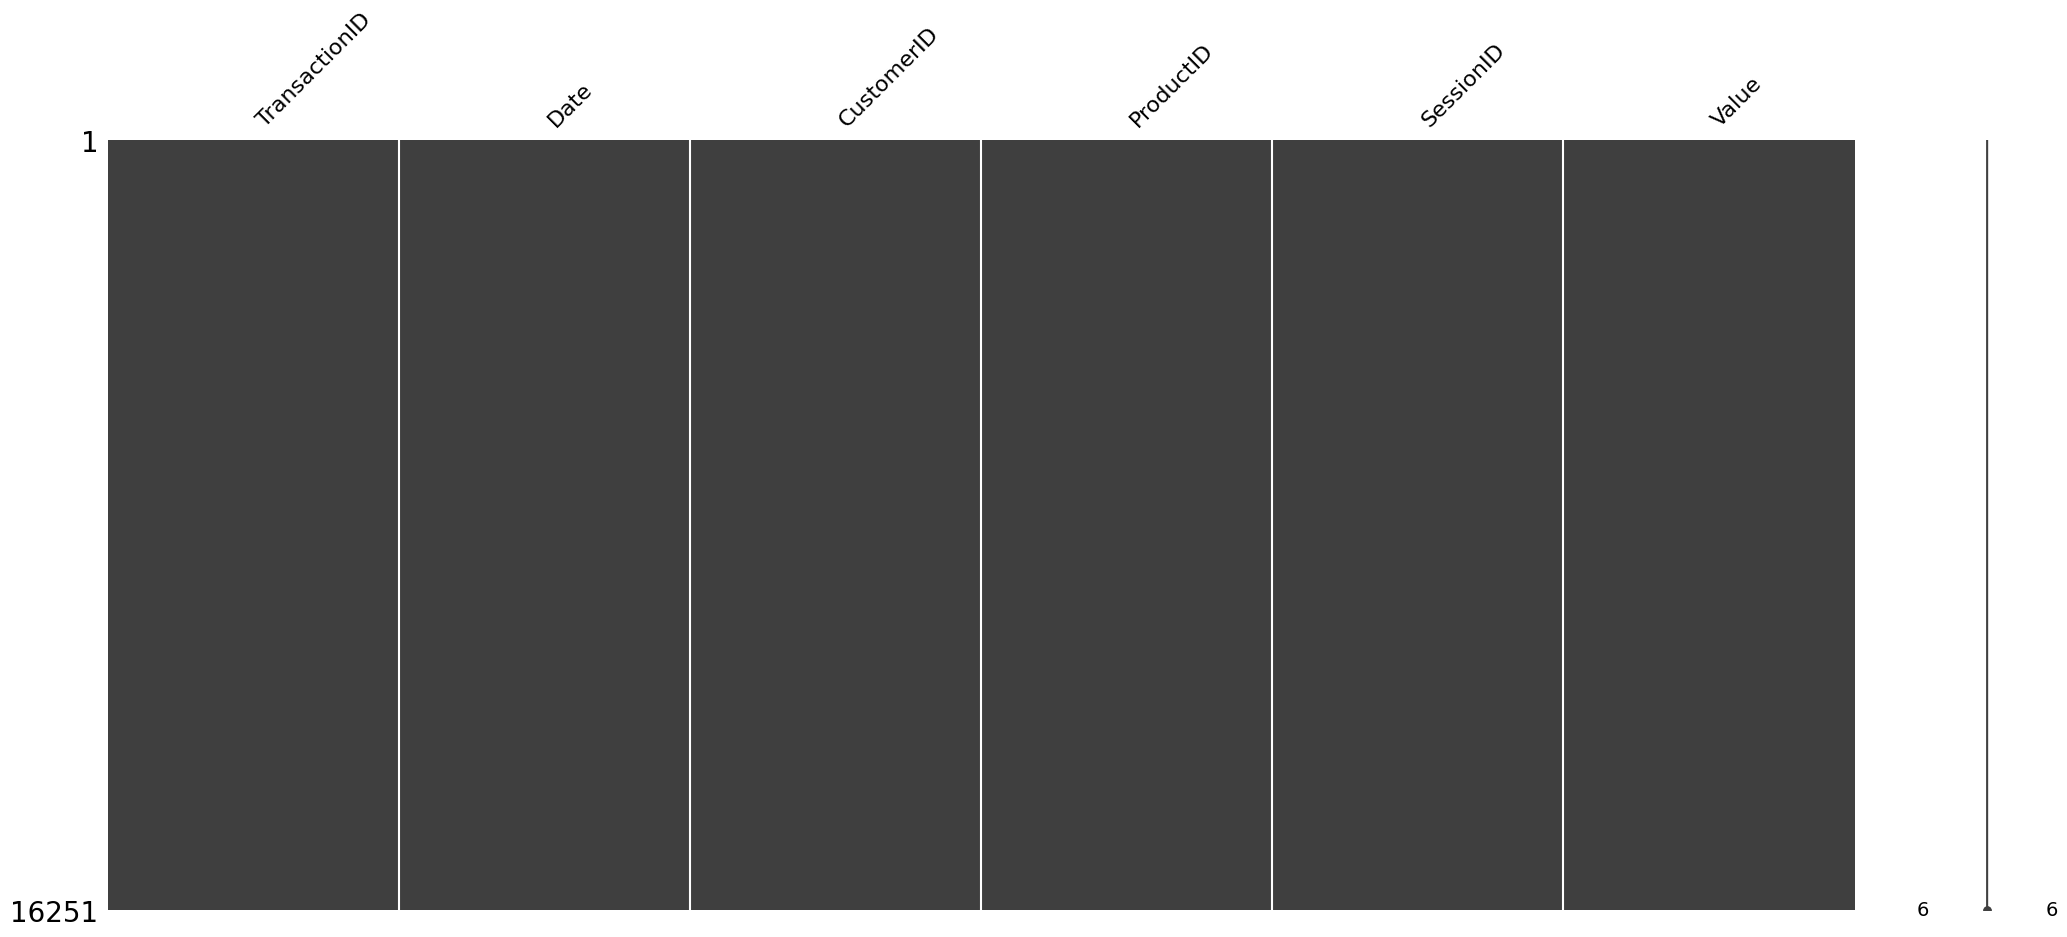

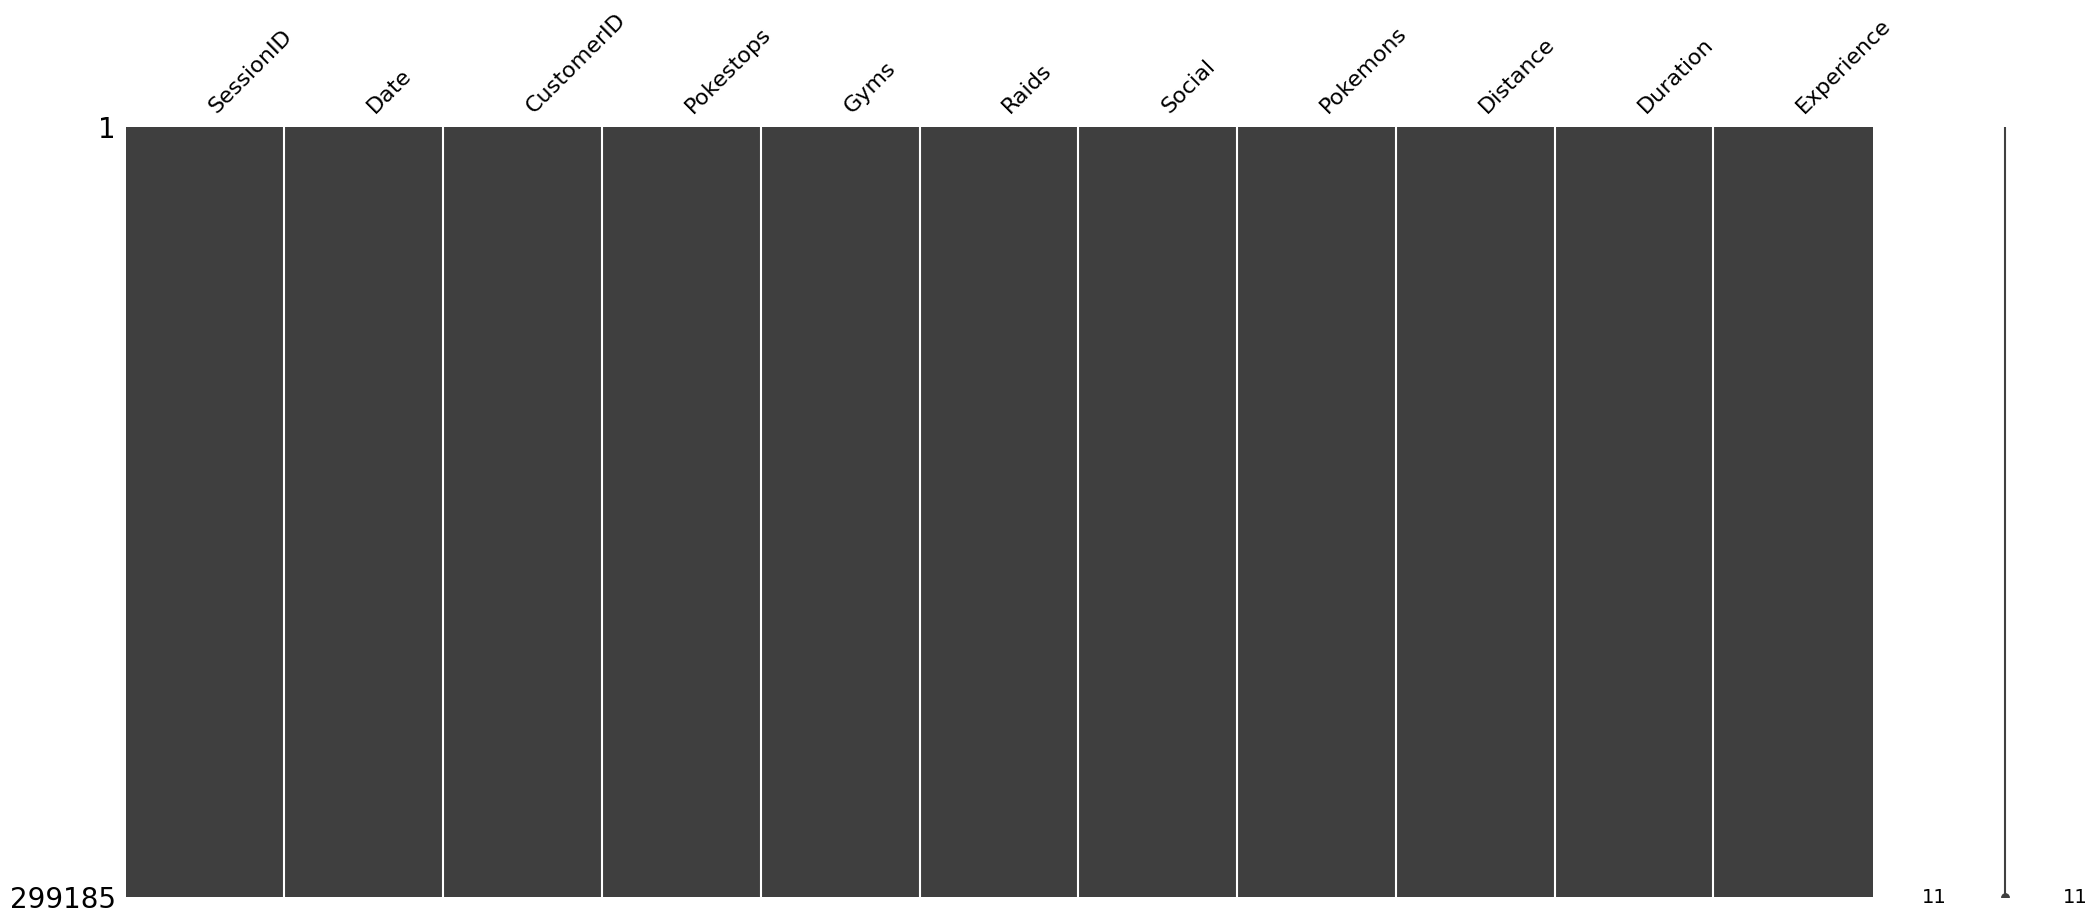

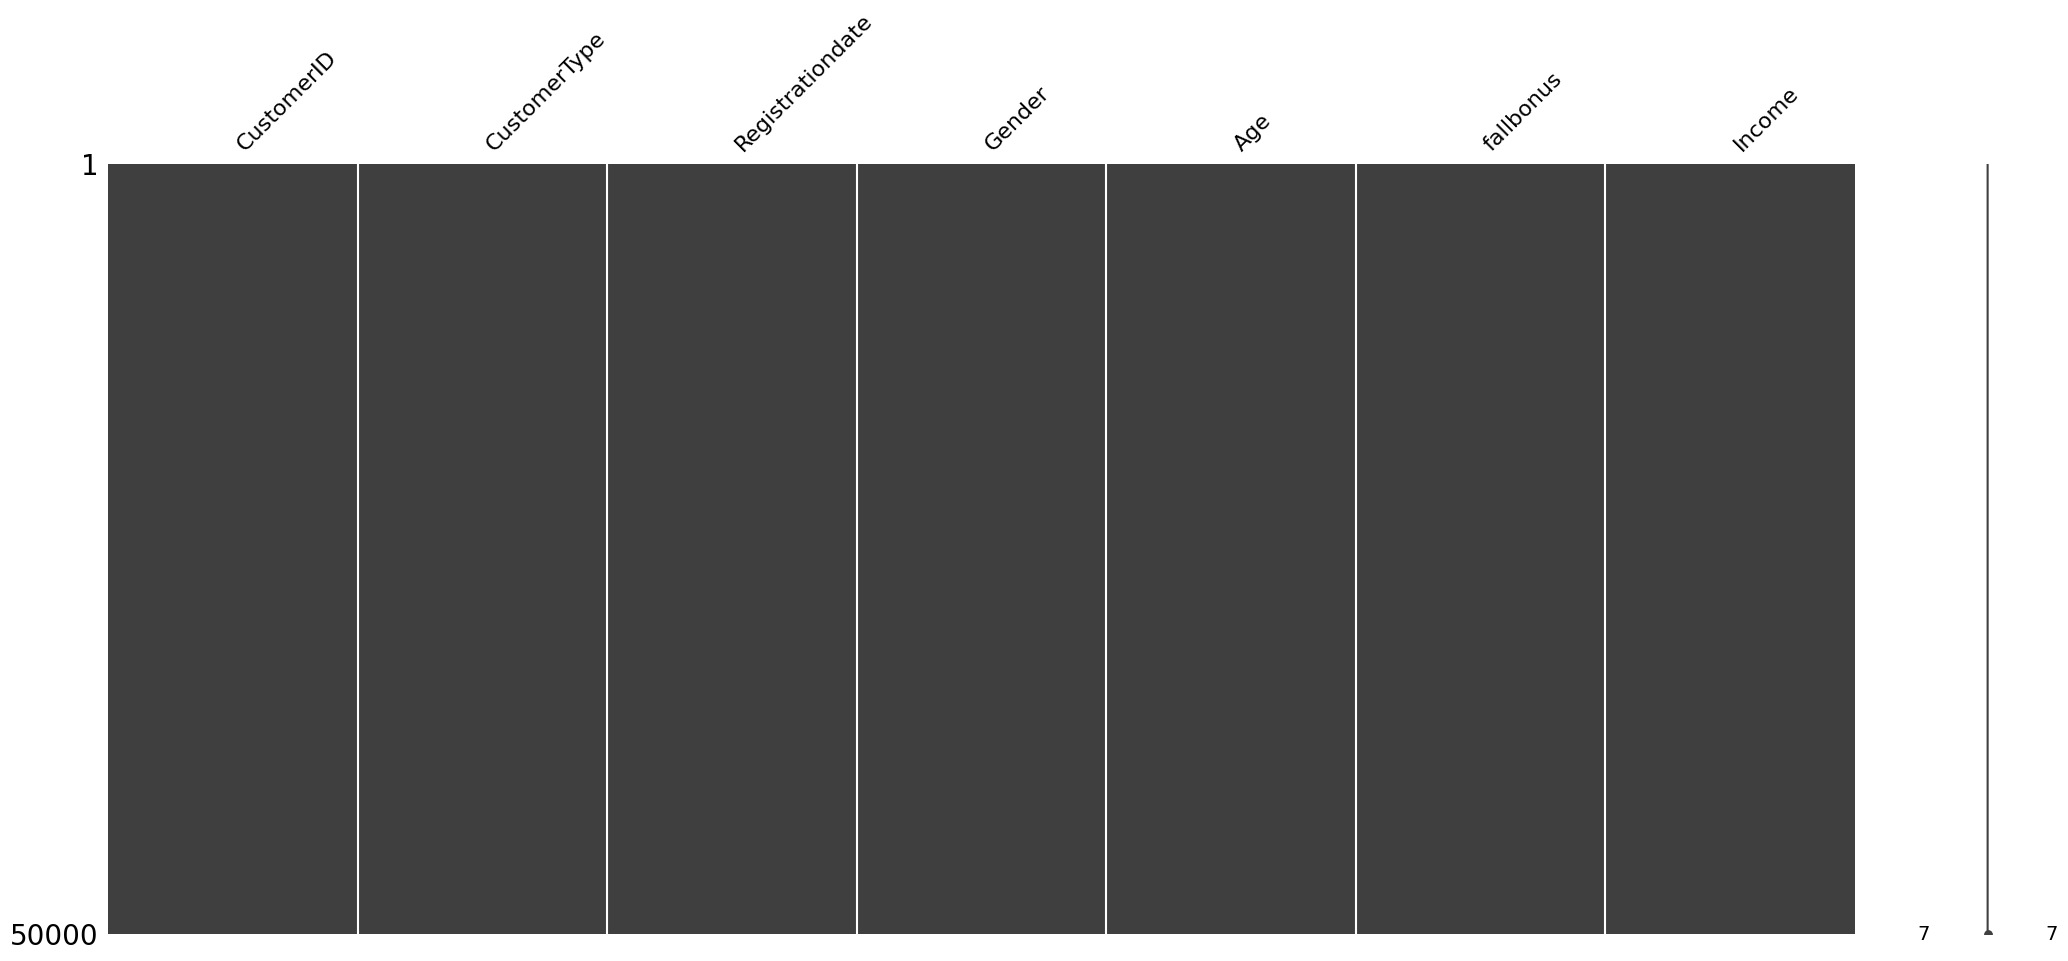

In [ ]:
#convert datetime to date (we don't need the hour)
summerfintrx['Date'] = pd.to_datetime(summerfintrx['Date']).dt.date
summersesstrx['Date'] = pd.to_datetime(summersesstrx['Date']).dt.date
fallfintrx['Date'] = pd.to_datetime(fallfintrx['Date']).dt.date
fallsesstrx['Date'] = pd.to_datetime(fallsesstrx['Date']).dt.date
customerdata['Registrationdate'] = pd.to_datetime(customerdata['Registrationdate']).dt.date

# Check for missing values in each dataset
missing_values_summary = {
    "summerfintrx": summerfintrx.isnull().sum(),
    "summersesstrx": summersesstrx.isnull().sum(),
    "fallfintrx": fallfintrx.isnull().sum(),
    "fallsesstrx": fallsesstrx.isnull().sum(),
    "customerdata": customerdata.isnull().sum(),
}

missing_values_df = pd.DataFrame(missing_values_summary)

missing_values_df

# viz
missingno.matrix(summerfintrx)
missingno.matrix(summersesstrx)
missingno.matrix(fallfintrx)
missingno.matrix(fallsesstrx)
missingno.matrix(customerdata)


In [ ]:
summersesstrx.columns

Index(['SessionID', 'Date', 'CustomerID', 'Pokestops', 'Gyms', 'Raids',
       'Social', 'Pokemons', 'Distance', 'Duration', 'Experience'],
      dtype='object')

In [ ]:
# Fill missing values in Income with the median income
customerdata['Income'].fillna(customerdata['Income'].median(), inplace=True)

# Drop duplicate entries in Customer Data
customerdata.drop_duplicates(subset=['CustomerID'], keep='first', inplace=True)

# ✅ Step 5: Create a Basetable for Active Customers (Played at least once in Summer)
summer_activity = summersesstrx.groupby('CustomerID', as_index=False).agg(session_count=('SessionID', 'count'))

# Merge with Customer Data
basetable = pd.merge(customerdata, summer_activity, on='CustomerID', how='left')

# Fill missing session counts (inactive players = 0)
basetable['session_count'].fillna(0, inplace=True)

# ✅ Step 6: Indicate whether the customer received the Fall Bonus
if 'Fallbonus' in customerdata.columns:
    basetable['Fall_Bonus'] = basetable['Fallbonus'].apply(lambda x: 'Yes' if x == 1 else 'No')
else:
    basetable['Fall_Bonus'] = 'No'  # If the column does not exist, assume no one received the bonus

# ✅ Step 7: Filter Active Customers (Played at least once in Summer)
active_customers = basetable[basetable['session_count'] > 0]

# ✅ Step 8: Compute RFM Metrics
end_date = datetime.date(2022, 8, 31)  # Last day of Summer period

rfm_data = summersesstrx.groupby('CustomerID', as_index=False).agg(
    frequency=('SessionID', 'count'),
    recency=('Date', lambda date: (end_date - date.max()).days)
)

# Calculate Monetary (Total Spending)
if 'Value' in summerfintrx.columns:
    monetary = summerfintrx.groupby('CustomerID', as_index=False).agg(monetary=('Value', 'sum'))
    rfm_data = rfm_data.merge(monetary, on='CustomerID', how='left')
    rfm_data['monetary'].fillna(0, inplace=True)  # Non-spenders get 0
else:
    rfm_data['monetary'] = 0  # If no spending data exists

# ✅ Step 9: Merge RFM Data with Demographic Data
demographic_data = customerdata[['CustomerID', 'Age', 'Gender', 'Income', 'CustomerType']]

# Ensure Gender is binary (0 = Male, 1 = Female)
demographic_data['males'] = (demographic_data['Gender'] == 0).astype(int)
demographic_data['females'] = (demographic_data['Gender'] == 1).astype(int)

# One-Hot Encode Income Levels (0 = Low, 1 = Medium, 2 = High)
demographic_data['low_income'] = (demographic_data['Income'] == 0).astype(int)
demographic_data['medium_income'] = (demographic_data['Income'] == 1).astype(int)
demographic_data['high_income'] = (demographic_data['Income'] == 2).astype(int)

# Merge RFM & Demographic Data
customer_profile = rfm_data.merge(demographic_data, on='CustomerID', how='left')

<ipython-input-6-89d1d9c0e2fd>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<ipython-input-6-89d1d9c0e2fd>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col]

In [ ]:
# ✅ Step 10: Compute Customer Lifetime Value (CLV)
discount_rate = 0.1  # 10% Discount Rate
gross_margin = 0.5  # 50% Profit Margin
future_months = 36  # Assume 3-year prediction

# Estimate Monthly Revenue
customer_profile['avg_monthly_revenue'] = customer_profile['monetary'] / customer_profile['frequency']
customer_profile['avg_monthly_revenue'].fillna(0, inplace=True)

# Random Retention Rate (Between 70-90%)
customer_profile['retention_rate'] = np.random.uniform(0.7, 0.9, size=len(customer_profile))

# Compute CLV
customer_profile['CLV'] = ((customer_profile['avg_monthly_revenue'] * gross_margin * (1 + discount_rate)) /
                           (1 + discount_rate - customer_profile['retention_rate'])) * future_months

customer_profile['CLV'] = customer_profile['CLV'].replace([np.inf, -np.inf], np.nan).fillna(0)

# ✅ Step 11: Descriptive Statistics
print("----- RFM Metrics -----")
print(customer_profile[['recency', 'frequency', 'monetary']].describe())

print("\n----- Demographic Metrics -----")
print(customer_profile[['Age', 'males', 'females', 'low_income', 'medium_income', 'high_income']].describe())

----- RFM Metrics -----
            recency     frequency      monetary
count  49763.000000  49763.000000  49763.000000
mean      16.599924      7.621546      3.987536
std       16.500205      2.527075     10.688428
min        1.000000      1.000000      0.000000
25%        5.000000      6.000000      0.000000
50%       11.000000      8.000000      0.000000
75%       23.000000     10.000000      2.990000
max      122.000000     14.000000    212.980000

----- Demographic Metrics -----
                Age         males       females    low_income  medium_income  \
count  49763.000000  49763.000000  49763.000000  49763.000000   49763.000000   
mean      27.813416      0.600667      0.399333      0.399695       0.327151   
std       13.636048      0.489766      0.489766      0.489840       0.469178   
min        6.000000      0.000000      0.000000      0.000000       0.000000   
25%       18.000000      0.000000      0.000000      0.000000       0.000000   
50%       28.000000      1.0000

<ipython-input-7-8e95a5c102d5>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [ ]:
print(customerdata['Income'].unique())

[0 2 1]



----- RFM Metrics (Recency, Frequency, Monetary) -----
            recency     frequency      monetary
count  49763.000000  49763.000000  49763.000000
mean      16.599924      7.621546      3.987536
std       16.500205      2.527075     10.688428
min        1.000000      1.000000      0.000000
25%        5.000000      6.000000      0.000000
50%       11.000000      8.000000      0.000000
75%       23.000000     10.000000      2.990000
max      122.000000     14.000000    212.980000

----- Age Distribution -----
count    49763.000000
mean        27.813416
std         13.636048
min          6.000000
25%         18.000000
50%         28.000000
75%         34.000000
max         80.000000
Name: Age, dtype: float64

----- Gender Distribution (%) -----
males      60.066716
females    39.933284
dtype: float64

----- Income Level Distribution (%) -----
low_income       39.969455
medium_income    32.715069
high_income      27.315475
dtype: float64

----- Usage Statistics (Average Per Customer) 

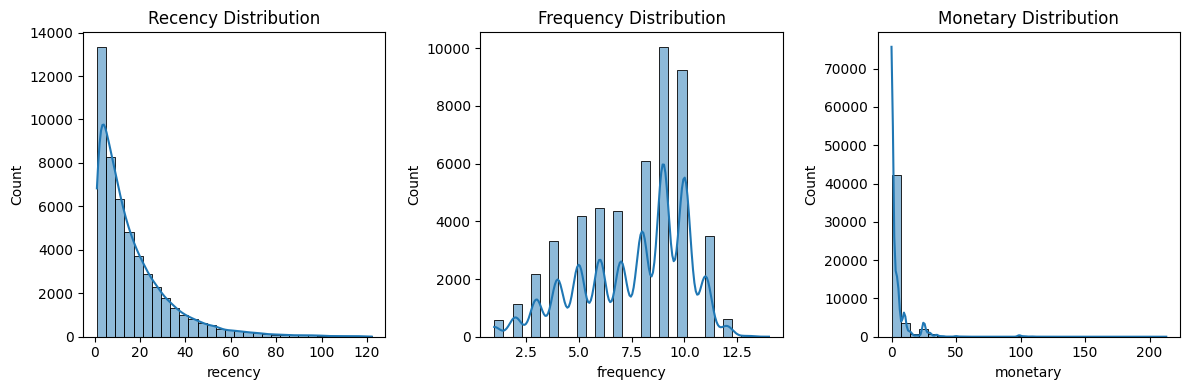

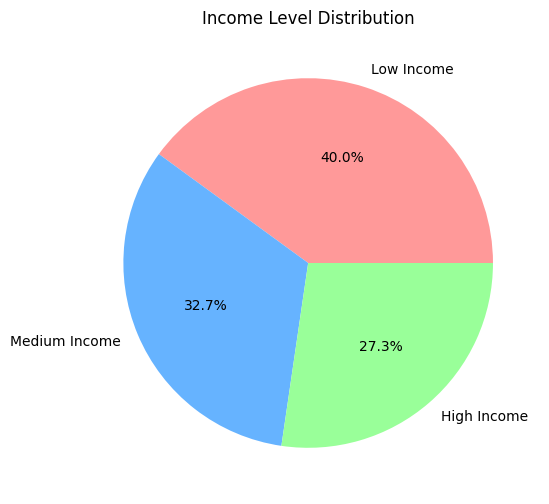

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [ ]:
# ✅ RFM Metrics (Continuous Variables)
print("\n----- RFM Metrics (Recency, Frequency, Monetary) -----")
rfm_summary = customer_profile[['recency', 'frequency', 'monetary']].describe()
print(rfm_summary)

# ✅ Age Distribution (Continuous Variable)
print("\n----- Age Distribution -----")
age_summary = customer_profile['Age'].describe()
print(age_summary)

# ✅ Gender Distribution (Binary Variable)
print("\n----- Gender Distribution (%) -----")
gender_distribution = customer_profile[['males', 'females']].mean() * 100
print(gender_distribution)

# ✅ Income Level Distribution (Categorical Variable)
print("\n----- Income Level Distribution (%) -----")
income_distribution = customer_profile[['low_income', 'medium_income', 'high_income']].mean() * 100
print(income_distribution)

# ✅ Fall Bonus Distribution (Binary Variable)
if 'Fall_Bonus' in customer_profile.columns:
    print("\n----- Fall Bonus Distribution (%) -----")
    fall_bonus_distribution = customer_profile['Fall_Bonus'].value_counts(normalize=True) * 100
    print(fall_bonus_distribution)

# ✅ Usage Patterns (Continuous Variables)
print("\n----- Usage Statistics (Average Per Customer) -----")
usage_summary = summersesstrx.groupby('CustomerID').agg(
    avg_pokestops=('Pokestops', 'mean'),
    avg_gyms=('Gyms', 'mean'),
    avg_raids=('Raids', 'mean'),
    avg_social=('Social', 'mean'),
    avg_pokemons=('Pokemons', 'mean'),
    avg_distance=('Distance', 'mean'),
    avg_duration=('Duration', 'mean'),
    avg_experience=('Experience', 'mean')
).mean()  # Taking the mean over all customers
print(usage_summary)

# ✅ Visualizing the Data

# 📌 RFM Distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(customer_profile['recency'], kde=True, bins=30)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(customer_profile['frequency'], kde=True, bins=30)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(customer_profile['monetary'], kde=True, bins=30)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

# 📌 Income Level Distribution
plt.figure(figsize=(6, 6))
income_labels = ['Low Income', 'Medium Income', 'High Income']
income_values = [
    customer_profile['low_income'].mean(),
    customer_profile['medium_income'].mean(),
    customer_profile['high_income'].mean()
]
plt.pie(income_values, labels=income_labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Income Level Distribution')
plt.show()

# 📌 Gender Distribution
plt.figure(figsize=(6, 6))

In [ ]:
customer_profile.columns

Index(['CustomerID', 'frequency', 'recency', 'monetary', 'Age', 'Gender',
       'Income', 'CustomerType', 'males', 'females', 'low_income',
       'medium_income', 'high_income', 'avg_monthly_revenue', 'retention_rate',
       'CLV'],
      dtype='object')

##CLV Interpretation


----- Customer Lifetime Value (CLV) Summary -----
count    49763.000000
mean        34.142337
std         98.203120
min          0.000000
25%          0.000000
50%          0.000000
75%         30.996559
max       3794.898274
Name: CLV, dtype: float64


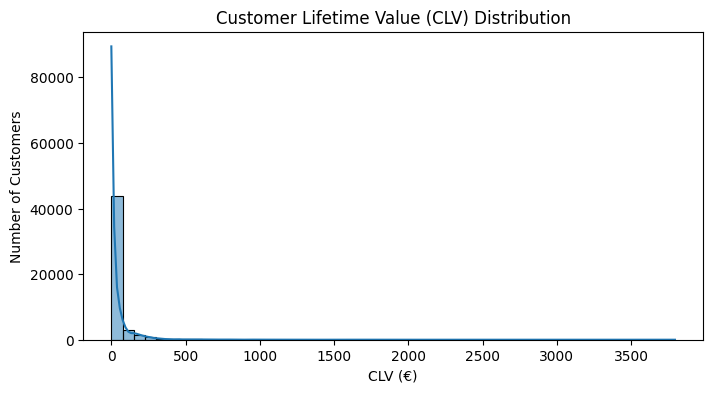

In [ ]:

# ✅ Step 1: Summary Statistics of CLV
print("\n----- Customer Lifetime Value (CLV) Summary -----")
clv_summary = customer_profile['CLV'].describe()
print(clv_summary)

# ✅ Step 2: Visualizing CLV Distribution
plt.figure(figsize=(8, 4))
sns.histplot(customer_profile['CLV'], bins=50, kde=True)
plt.title('Customer Lifetime Value (CLV) Distribution')
plt.xlabel('CLV (€)')
plt.ylabel('Number of Customers')
plt.show()


##Question - 2


----- Lifecycle Grid Summary -----
Lifecycle Segment
Regular & Non-Spender                8512
Highly Engaged & Non-Spender         8490
Dormant & Non-Spender                8253
Casual & Non-Spender                 7338
Dormant & Moderate Spender           2421
Regular & Moderate Spender           2113
Casual & Moderate Spender            2045
Highly Engaged & Moderate Spender    1464
Dormant & Low Spender                1414
Regular & Low Spender                1317
Dormant & High Spender               1257
Casual & Low Spender                 1161
Regular & High Spender               1132
Casual & High Spender                1119
Highly Engaged & Low Spender         1006
Highly Engaged & High Spender         721
Name: count, dtype: int64


<ipython-input-12-93f833bbabed>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



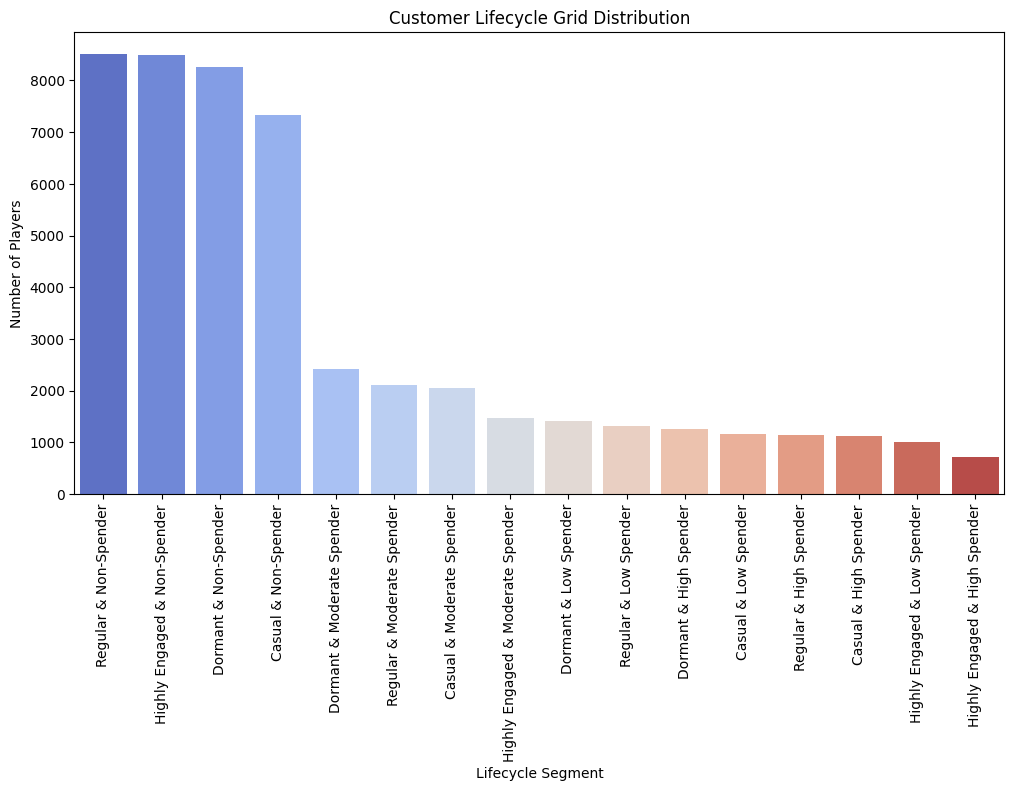

In [ ]:
# ✅ Step 1: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Step 2: Define Engagement-Based Segmentation (Recency & Frequency)
def assign_quartile(df, column, labels):
    return pd.qcut(df[column], q=4, labels=labels)

# Engagement Segments (Based on Recency & Frequency)
engagement_labels = ["Dormant", "Casual", "Regular", "Highly Engaged"]

customer_profile['Engagement'] = assign_quartile(customer_profile, 'recency', engagement_labels)
customer_profile['Frequency Group'] = assign_quartile(customer_profile, 'frequency', engagement_labels)

# ✅ Step 3: Fix Spending Segmentation (Using `pd.cut()` Instead of `qcut()`)
# Define Spending Bins Manually
spending_bins = [-1, 0, 2.99, 10, customer_profile['monetary'].max()]
spending_labels = ["Non-Spender", "Low Spender", "Moderate Spender", "High Spender"]

# Apply Spending Segmentation
customer_profile['Spender Group'] = pd.cut(customer_profile['monetary'], bins=spending_bins, labels=spending_labels)

# ✅ Step 4: Create Lifecycle Grid (Combine Engagement & Spending)
customer_profile['Lifecycle Segment'] = customer_profile['Engagement'].astype(str) + " & " + customer_profile['Spender Group'].astype(str)

# ✅ Step 5: Count Customers in Each Lifecycle Segment
lifecycle_counts = customer_profile['Lifecycle Segment'].value_counts()
print("\n----- Lifecycle Grid Summary -----")
print(lifecycle_counts)

# ✅ Step 6: Visualize Lifecycle Grid Distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=lifecycle_counts.index, y=lifecycle_counts.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.title('Customer Lifecycle Grid Distribution')
plt.xlabel('Lifecycle Segment')
plt.ylabel('Number of Players')
plt.show()

# 📊 Customer Lifecycle Grid Analysis

## 🔍 Key Observations:
1. **Regular & Non-Spenders and Highly Engaged & Non-Spenders dominate the player base.**
   - These players engage frequently but do not contribute financially.
   - High engagement suggests a strong affinity for the game but reluctance to spend.

2. **Dormant & Non-Spenders and Casual & Non-Spenders form a significant portion.**
   - These segments have low activity and do not contribute to revenue.
   - They risk becoming completely inactive if engagement isn't stimulated.

3. **Spender Segments (Moderate & High Spenders) are significantly smaller.**
   - Dormant, Casual, and Regular spenders exist, but their numbers are not high.
   - **High-value players ("Whales") are the smallest category**, yet they drive revenue.

---

## 📈 Business Insights & Recommendations:

### 🎯 1. Convert Non-Spenders into Paying Players  
- **Issue:** The majority of engaged players do not spend money.  
- **Actionable Strategies:**  
  - Introduce **first-time purchase discounts** or **exclusive in-game items**.  
  - Implement **time-limited microtransactions** to create urgency.  
  - Provide **seasonal/limited-edition bundles** to encourage spending.

### 🔄 2. Reactivate Dormant Players  
- **Issue:** A large portion of the database consists of disengaged or inactive users.  
- **Actionable Strategies:**  
  - Send **personalized re-engagement emails** offering in-game rewards.  
  - Host **"Comeback Events"** with unique rewards for returning players.  
  - Offer **progress boosters** for those who haven’t played in a while.

### 🎮 3. Increase Engagement Among Casual Players  
- **Issue:** Casual & Non-Spenders are at risk of dropping off completely.  
- **Actionable Strategies:**  
  - Introduce **daily login rewards** to maintain activity.  
  - Create **social incentives** for group play (e.g., team-based rewards).  
  - Develop **seasonal content drops** to keep interest high.

### 💰 4. Retain & Expand High Spenders ("Whales")  
- **Issue:** The most valuable players are a very small fraction of the base.  
- **Actionable Strategies:**  
  - Provide **VIP rewards, exclusive items, and early access content** for high spenders.  
  - Implement **subscription models** with premium benefits.  
  - Offer **personalized in-game experiences** (custom skins, special access).

---

## 📌 Final Business Recommendations:
- **🔼 Increase monetization efforts among non-spenders while maintaining engagement.**
- **♻️ Re-engage dormant players with tailored incentives and comeback events.**
- **🎯 Strengthen loyalty programs for high-value players to ensure long-term revenue.**
- **⚡ Use social and event-based features to keep casual players engaged and spending.**

🚀 **By implementing these strategies, Niantic can drive higher engagement, increase revenue, and sustain long-term player retention.**  

##Microtransaction Behavior Grid


----- Microtransaction Spending Grid -----
Spender Type
Free-Only Player        32593
Impulsive Buyer         12941
Strategic Spender        3809
Whale (High Spender)      420
Name: count, dtype: int64


<ipython-input-13-15c3521f6455>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



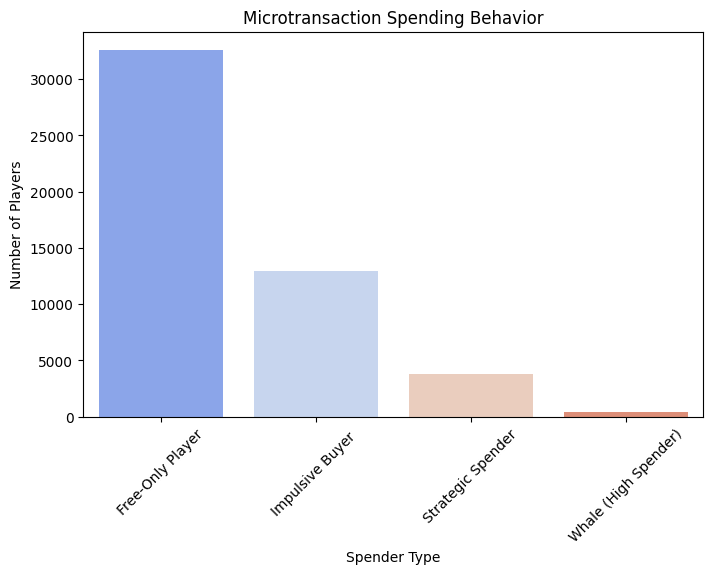

In [ ]:
# ✅ Step 1: Define Spending Segments
def classify_spender(row):
    if row['monetary'] == 0:
        return "Free-Only Player"
    elif row['monetary'] > 0 and row['monetary'] < 10:
        return "Impulsive Buyer "
    elif row['monetary'] >= 10 and row['monetary'] < 50:
        return "Strategic Spender"
    else:
        return "Whale (High Spender)"

# ✅ Step 2: Apply Classification to Dataset
customer_profile['Spender Type'] = customer_profile.apply(classify_spender, axis=1)

# ✅ Step 3: Count Players in Each Spending Category
spender_counts = customer_profile['Spender Type'].value_counts()
print("\n----- Microtransaction Spending Grid -----")
print(spender_counts)

# ✅ Step 4: Visualize Spending Behavior
plt.figure(figsize=(8, 5))
sns.barplot(x=spender_counts.index, y=spender_counts.values, palette="coolwarm")
plt.title('Microtransaction Spending Behavior')
plt.xlabel('Spender Type')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.show()

In [ ]:
customer_profile.columns

Index(['CustomerID', 'frequency', 'recency', 'monetary', 'Age', 'Gender',
       'Income', 'CustomerType', 'males', 'females', 'low_income',
       'medium_income', 'high_income', 'avg_monthly_revenue', 'retention_rate',
       'CLV', 'Engagement', 'Frequency Group', 'Spender Group',
       'Lifecycle Segment', 'Spender Type'],
      dtype='object')

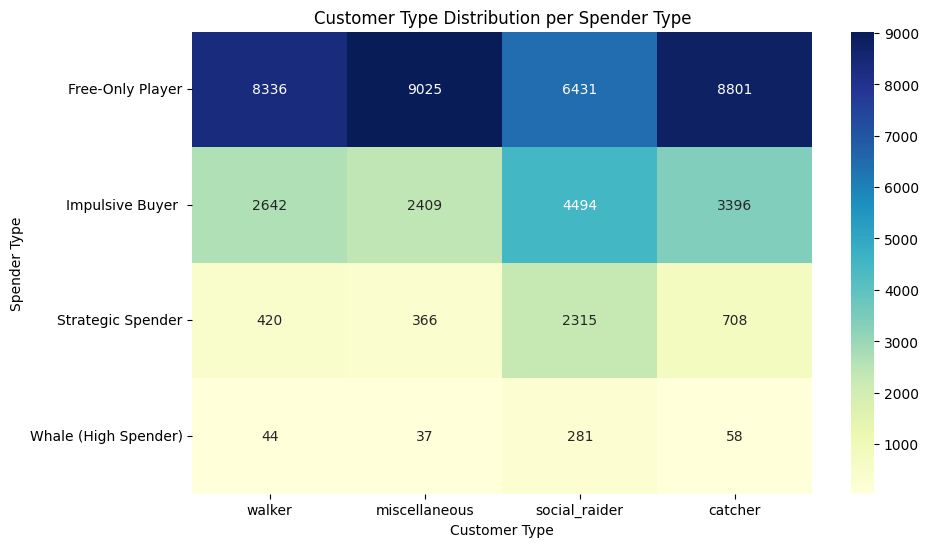

In [ ]:
#Customer type distribution per spender type
# Create a cross-tabulation (contingency table)
spender_customer_type = pd.crosstab(customer_profile['Spender Type'], customer_profile['CustomerType'])

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(spender_customer_type, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Customer Type Distribution per Spender Type")
plt.xlabel("Customer Type")
plt.ylabel("Spender Type")

# Change x-axis labels
customer_type_labels = ['walker', 'miscellaneous', 'social_raider', 'catcher']  # New labels

# Get positions for x-axis ticks
num_cols = spender_customer_type.shape[1]
tick_positions = np.arange(0.5, num_cols + 0.5)

# Set x-axis ticks and labels
plt.xticks(tick_positions, labels=customer_type_labels, rotation=0, ha='center')

plt.show()

In [ ]:
summersesstrx['Duration'].describe()

,Duration
count,379271.000000
mean,66.837787
std,42.785957
min,5.828665
25%,31.773864
50%,53.738999
75%,94.756357
max,303.425316


1️⃣ Engagement Grid (Session-Based)

📌 Purpose: Identify how often players engage with the game.
🎯 Business Use Case: Helps re-engage inactive players and boost session frequency.

🔹 Player Segments

	•	Casual Players → Fewer than 10 sessions in summer.
	•	Regular Players → Between 10–30 sessions.
	•	Hardcore Players → More than 30 sessions.

<ipython-input-17-50a8957351b1>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



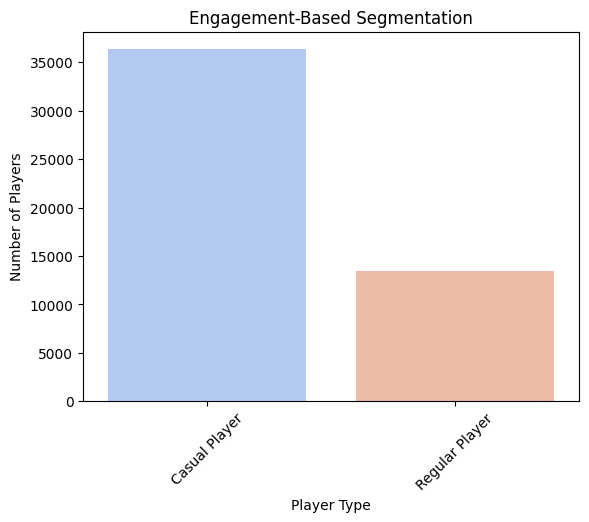

In [ ]:
# Step 1: Count Number of Sessions Per Player
session_counts = summersesstrx.groupby('CustomerID')['SessionID'].count().reset_index()
session_counts.rename(columns={'SessionID': 'Total_Sessions'}, inplace=True)

# Step 2: Define Player Segments
def classify_session_based(player_sessions):
    if player_sessions < 10:
        return "Casual Player"
    elif 10 <= player_sessions <= 30:
        return "Regular Player"
    else:
        return "Hardcore Player"

# Step 3: Apply Classification
session_counts['Engagement Segment'] = session_counts['Total_Sessions'].apply(classify_session_based)

# Step 4: Merge into Customer Profile
customer_profile = customer_profile.merge(session_counts[['CustomerID', 'Engagement Segment']], on='CustomerID', how='left')

# Step 5: Count & Visualize
engagement_counts = customer_profile['Engagement Segment'].value_counts()
sns.barplot(x=engagement_counts.index, y=engagement_counts.values, palette="coolwarm")
plt.title('Engagement-Based Segmentation')
plt.xlabel('Player Type')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.show()

2️⃣ Spending Grid (Monetary-Based)

📌 Purpose: Identify high-value spenders.
🎯 Business Use Case: Helps Niantic target paying users & increase in-game purchases.

🔹 Player Segments

	•	Non-Spenders → Players who did not make purchases.
	•	Low Spenders → Spent < €10 in summer.
	•	Moderate Spenders → Spent €10–50.
	•	High Spenders → Spent > €50.

<ipython-input-18-8474d4a1c8b1>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



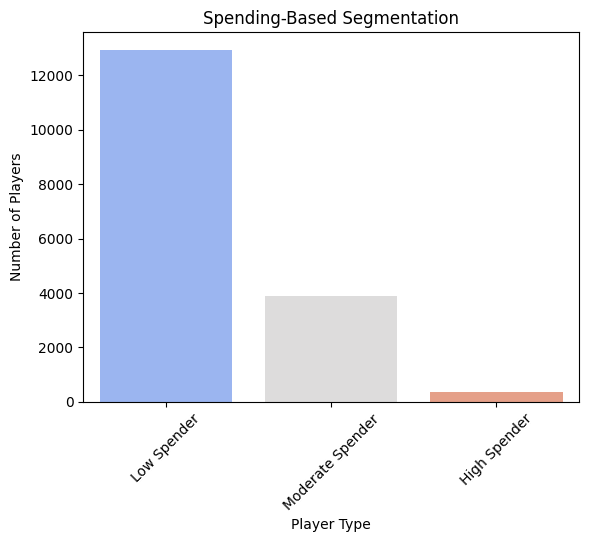

In [ ]:
# Step 1: Calculate Total Spending Per Player
monetary_data = summerfintrx.groupby('CustomerID')['Value'].sum().reset_index()
monetary_data.rename(columns={'Value': 'Total_Spending'}, inplace=True)

# Step 2: Define Spending Segments
def classify_spending_based(spending):
    if spending == 0:
        return "Non-Spender"
    elif spending < 10:
        return "Low Spender"
    elif 10 <= spending <= 50:
        return "Moderate Spender"
    else:
        return "High Spender"

# Step 3: Apply Classification
monetary_data['Spending Segment'] = monetary_data['Total_Spending'].apply(classify_spending_based)

# Step 4: Merge into Customer Profile
customer_profile = customer_profile.merge(monetary_data[['CustomerID', 'Spending Segment']], on='CustomerID', how='left')

# Step 5: Count & Visualize
spending_counts = customer_profile['Spending Segment'].value_counts()
sns.barplot(x=spending_counts.index, y=spending_counts.values, palette="coolwarm")
plt.title('Spending-Based Segmentation')
plt.xlabel('Player Type')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.show()

3️⃣ Exploration Grid (Distance-Based)

📌 Purpose: Understand player movement.
🎯 Business Use Case: Helps Niantic optimize outdoor events & reward active explorers.

🔹 Player Segments

	•	Stationary Players → Walk < 1 km per session.
	•	Casual Explorers → Walk 1–2.5 km per session.
	•	Active Explorers → Walk > 2.5 km per session.

<ipython-input-19-ce6939b31bf4>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



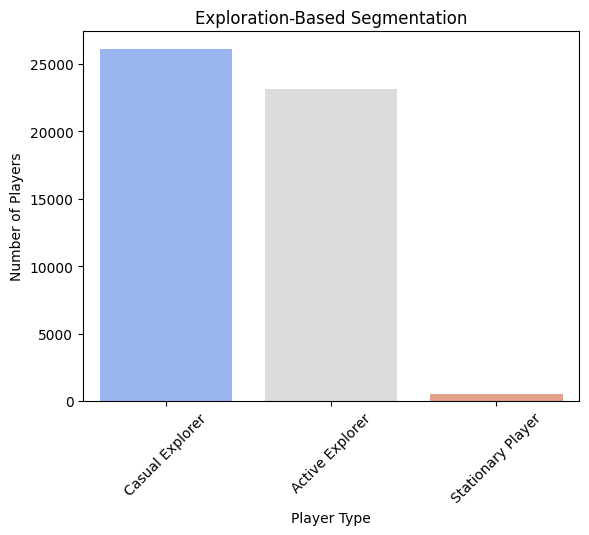

In [ ]:
# Step 1: Calculate Average Distance Per Player
distance_data = summersesstrx.groupby('CustomerID')['Distance'].mean().reset_index()
distance_data.rename(columns={'Distance': 'Avg_Distance'}, inplace=True)

# Step 2: Define Distance-Based Segments
def classify_exploration_based(distance):
    if distance < 1:
        return "Stationary Player"
    elif 1 <= distance <= 2.5:
        return "Casual Explorer"
    else:
        return "Active Explorer"

# Step 3: Apply Classification
distance_data['Exploration Segment'] = distance_data['Avg_Distance'].apply(classify_exploration_based)

# Step 4: Merge into Customer Profile
customer_profile = customer_profile.merge(distance_data[['CustomerID', 'Exploration Segment']], on='CustomerID', how='left')

# Step 5: Count & Visualize
exploration_counts = customer_profile['Exploration Segment'].value_counts()
sns.barplot(x=exploration_counts.index, y=exploration_counts.values, palette="coolwarm")
plt.title('Exploration-Based Segmentation')
plt.xlabel('Player Type')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.show()

In [ ]:
customer_profile.columns

Index(['CustomerID', 'frequency', 'recency', 'monetary', 'Age', 'Gender',
       'Income', 'CustomerType', 'males', 'females', 'low_income',
       'medium_income', 'high_income', 'avg_monthly_revenue', 'retention_rate',
       'CLV', 'Engagement', 'Frequency Group', 'Spender Group',
       'Lifecycle Segment', 'Spender Type', 'Engagement Segment',
       'Spending Segment', 'Exploration Segment'],
      dtype='object')

📌 **Conclusion: Final Business Insights**

| **Finding** | **Key Takeaways for Niantic** |
|------------|--------------------------------|
| **Low engagement among casual players** | Boost daily logins with streak rewards & notifications. |
| **Most players are non-spenders** | Convert them using first-time purchase incentives & discounts. |
| **Players explore different distances** | Create movement-based rewards & real-world partnerships. |
| **Social play is underutilized** | Encourage more raids & gym battles through rewards. |
| **High spenders ("whales") drive revenue** | Cater to them with exclusive premium content. |

# 📊 Pokémon GO Player Lifecycle Analysis

## **1️⃣ Engagement-Based Segmentation**
📌 **What it Measures**: Frequency of gameplay sessions.  
📌 **Findings**:
- Majority (~75%) are **Casual Players** with low engagement.
- Only ~25% are **Regular Players** who engage frequently.  
📌 **Key Takeaways**:
✅ **Encourage daily logins** with streak-based rewards.  
✅ **Use push notifications** to remind players about events.  
✅ **Convert casuals to regulars** via time-sensitive bonuses.

---

## **2️⃣ Spending-Based Segmentation**
📌 **What it Measures**: Microtransaction behavior.  
📌 **Findings**:
- **~85% are non-spenders or low spenders**.  
- **Moderate & high spenders (~15%) drive revenue**.  
📌 **Key Takeaways**:
✅ **Offer first-time purchase discounts** to convert non-spenders.  
✅ **Introduce exclusive “VIP” rewards** for moderate spenders.  
✅ **Cater to “Whale Spenders”** with premium in-game content.

---

## **3️⃣ Exploration-Based Segmentation**
📌 **What it Measures**: Distance traveled while playing.  
📌 **Findings**:
- ~50% are **Casual Explorers**, moderate movement.
- ~45% are **Active Explorers**, heavy movement.
- ~5% are **Stationary Players**, low movement.  
📌 **Key Takeaways**:
✅ **Encourage movement-based rewards** (e.g., 5 km challenge).  
✅ **Partner with real-world locations** for **Stationary Players**.  
✅ **Launch walking challenges** to promote outdoor play.

---

## **4️⃣ Social Engagement Segmentation**
📌 **What it Measures**: Interaction with raids, gyms & multiplayer.  
📌 **Findings**:
- **Most players do not engage socially**.
- **Socially active players have higher retention & engagement**.  
📌 **Key Takeaways**:
✅ **Offer bonus XP & rewards** for gym battles & raids.  
✅ **Introduce in-game chat & matchmaking** to encourage teamwork.  
✅ **Create leaderboard-based social challenges**.

---

## **5️⃣ Microtransaction Behavior**
📌 **What it Measures**: Types of in-game purchases.  
📌 **Findings**:
- **Free-Only Players (~65%) dominate.**
- **Impulsive Buyers (~25%) make occasional purchases.**
- **Strategic Spenders (~8%) and Whale Spenders (~2%) drive revenue.**  
📌 **Key Takeaways**:
✅ **Limited-time deals** to **convert impulsive buyers** into repeat spenders.  
✅ **Subscription-based plans** for **strategic spenders**.  
✅ **Ultra-premium items** for **whale spenders**.

---

## **📌 Final Business Insights**
| **Finding** | **Key Takeaways for Niantic** |
|------------|--------------------------------|
| **Low engagement among casual players** | Boost daily logins with streak rewards & notifications. |
| **Most players are non-spenders** | Convert them using first-time purchase incentives & discounts. |
| **Players explore different distances** | Create movement-based rewards & real-world partnerships. |
| **Social play is underutilized** | Encourage more raids & gym battles through rewards. |
| **High spenders ("whales") drive revenue** | Cater to them with exclusive premium content. |

---
### 🎯 **Final Strategy for Niantic**
- Focus on converting **casual players into regulars**.
- Target **low spenders with first-time discounts**.
- Incentivize **movement & outdoor engagement**.
- Boost **social interactions through rewards & matchmaking**.
- Enhance **premium content for high spenders**.

🚀 **Implementing these strategies will drive retention, engagement, and revenue growth for Pokémon GO.**

<ipython-input-21-ee895d181559>:33: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


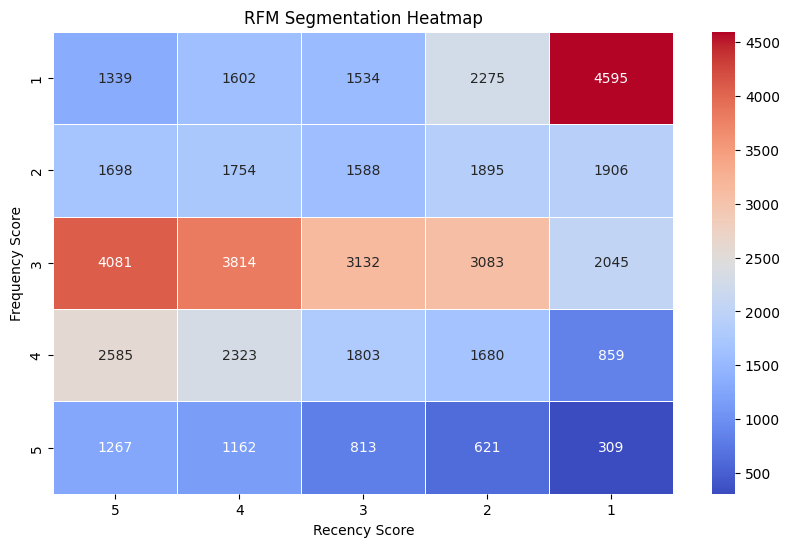


📌 RFM Segmentation Summary:
               RFM Segment  Number of Players
0     Potential Loyalists              19196
1             New Players               8293
2     Hibernating Players               7253
3  Need Attention Players               6254
4            Lost Players               4595
5           Loyal Players               2905
6        Champion Players               1267


In [ ]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Extract Relevant RFM Columns ---
rfm_data = customer_profile[['CustomerID', 'recency', 'frequency', 'monetary']].copy()

# --- Step 2: Convert RFM Scores into Quantiles ---
rfm_data['recency_score'] = pd.qcut(rfm_data['recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm_data['frequency_score'] = pd.qcut(rfm_data['frequency'], q=5, labels=[1, 2, 3, 4, 5])

# --- Step 3: Define RFM Segments ---
def classify_rfm(row):
    if row['recency_score'] == 5 and row['frequency_score'] == 5:
        return 'Champion Players'
    elif row['frequency_score'] == 5:
        return 'Loyal Players'
    elif row['recency_score'] >= 4:
        return 'Potential Loyalists'
    elif row['recency_score'] >= 3 and row['frequency_score'] <= 3:
        return 'Need Attention Players'
    elif row['recency_score'] >= 2 and row['frequency_score'] <= 3:
        return 'Hibernating Players'
    elif row['recency_score'] == 1 and row['frequency_score'] == 1:
        return 'Lost Players'
    else:
        return 'New Players'

rfm_data['rfm_segment'] = rfm_data.apply(classify_rfm, axis=1)

# --- Step 4: Generate RFM Heatmap Data ---
heatmap_data = rfm_data.pivot_table(index='frequency_score', columns='recency_score', aggfunc='size', fill_value=0)

# --- Step 5: Generate the Heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title('RFM Segmentation Heatmap')
plt.xlabel('Recency Score')
plt.ylabel('Frequency Score')
plt.show()

# --- Step 6: Display RFM Summary ---
rfm_summary = rfm_data['rfm_segment'].value_counts().reset_index()
rfm_summary.columns = ['RFM Segment', 'Number of Players']
print("\n📌 RFM Segmentation Summary:\n", rfm_summary)

<ipython-input-22-5083e5259b10>:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
<ipython-input-22-5083e5259b10>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


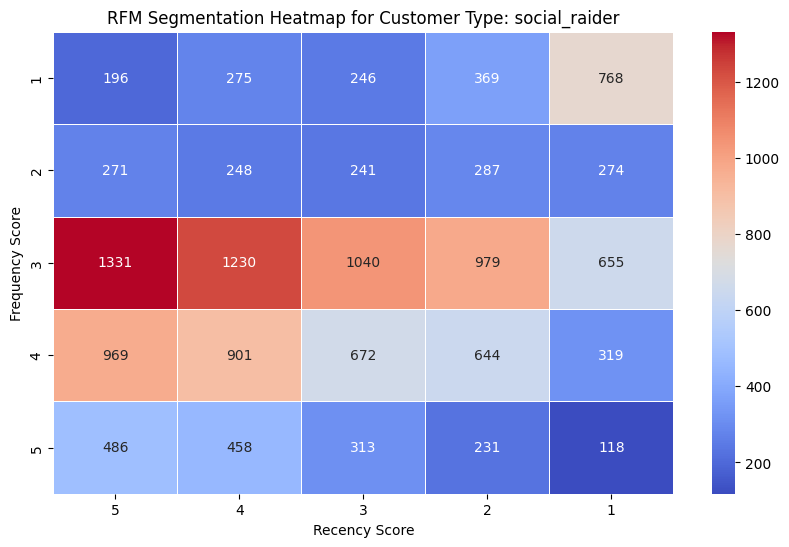


📌 RFM Segmentation Summary for social_raider:
               RFM Segment  Number of Players
0     Potential Loyalists               5421
1             New Players               2564
2     Hibernating Players               1635
3  Need Attention Players               1527
4           Loyal Players               1120
5            Lost Players                768
6        Champion Players                486


<ipython-input-22-5083e5259b10>:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
<ipython-input-22-5083e5259b10>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


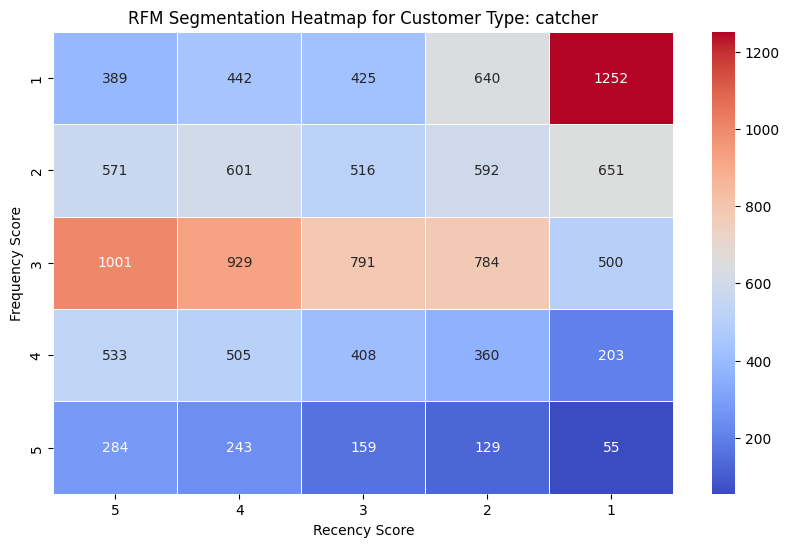


📌 RFM Segmentation Summary for catcher:
               RFM Segment  Number of Players
0     Potential Loyalists               4971
1             New Players               2122
2     Hibernating Players               2016
3  Need Attention Players               1732
4            Lost Players               1252
5           Loyal Players                586
6        Champion Players                284


<ipython-input-22-5083e5259b10>:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
<ipython-input-22-5083e5259b10>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


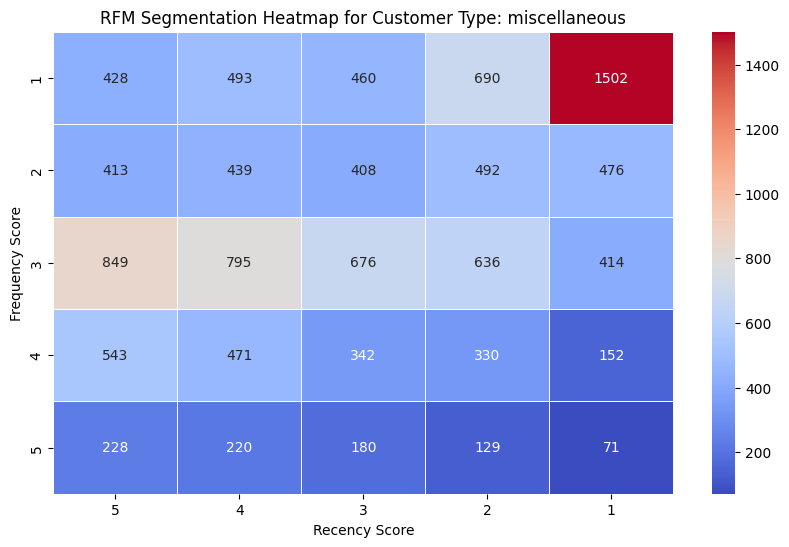


📌 RFM Segmentation Summary for miscellaneous:
               RFM Segment  Number of Players
0     Potential Loyalists               4431
1     Hibernating Players               1818
2             New Players               1714
3  Need Attention Players               1544
4            Lost Players               1502
5           Loyal Players                600
6        Champion Players                228


<ipython-input-22-5083e5259b10>:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
<ipython-input-22-5083e5259b10>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


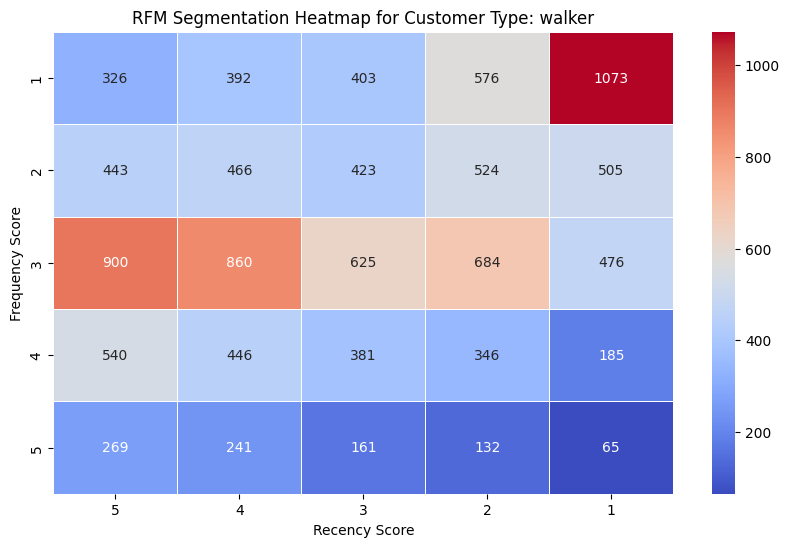


📌 RFM Segmentation Summary for walker:
               RFM Segment  Number of Players
0     Potential Loyalists               4373
1             New Players               1893
2     Hibernating Players               1784
3  Need Attention Players               1451
4            Lost Players               1073
5           Loyal Players                599
6        Champion Players                269


In [ ]:
# --- Step 1: Extract Relevant RFM & Customer Type Columns ---
rfm_data = customer_profile[['CustomerID', 'recency', 'frequency', 'monetary', 'CustomerType']].copy()

# --- Step 2: Convert RFM Scores into Quantiles ---
rfm_data['recency_score'] = pd.qcut(rfm_data['recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm_data['frequency_score'] = pd.qcut(rfm_data['frequency'], q=5, labels=[1, 2, 3, 4, 5])

# --- Step 3: Map Customer Type Numbers to Labels ---
customer_type_mapping = {
    0: 'walker',
    1: 'miscellaneous',
    2: 'social_raider',
    3: 'catcher'
}
rfm_data['CustomerType'] = rfm_data['CustomerType'].map(customer_type_mapping)

# --- Step 4: Create Separate Heatmaps for Each Customer Type ---
customer_types = rfm_data['CustomerType'].unique()

for customer_type in customer_types:
    # Filter data for the current customer type
    filtered_data = rfm_data[rfm_data['CustomerType'] == customer_type]

    # Generate heatmap data
    heatmap_data = filtered_data.pivot_table(
        index='frequency_score',
        columns='recency_score',
        aggfunc='size',
        fill_value=0
    )

    #Apply RFM classification to filtered data
    filtered_data['rfm_segment'] = filtered_data.apply(classify_rfm, axis=1)

    # Generate the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
    plt.title(f'RFM Segmentation Heatmap for Customer Type: {customer_type}')
    plt.xlabel('Recency Score')
    plt.ylabel('Frequency Score')
    plt.show()

    # --- Step 6: Display RFM Summary for filtered data---
    rfm_summary = filtered_data['rfm_segment'].value_counts().reset_index()
    rfm_summary.columns = ['RFM Segment', 'Number of Players']
    print(f"\n📌 RFM Segmentation Summary for {customer_type}:\n", rfm_summary)

## 📌 Segments that Negatively Affect the Company

### 1️⃣ Lost Players (4,595 players)
- **These are players who have the lowest frequency and highest recency (they haven’t played in a long time and don’t engage).**  
- **🛑 Negative Impact:** They no longer contribute to engagement or revenue.  
- **✅ Actionable Insight:** Consider **re-engagement campaigns** (email reminders, event incentives).  

---

### 2️⃣ Need Attention Players (6,254 players)
- **These players have decent past engagement but are showing signs of disengagement.**  
- **🛑 Negative Impact:** If they drop off, they could transition into Lost Players.  
- **✅ Actionable Insight:** Identify **why they are disengaging** and offer **personalized promotions**.  

---

### 3️⃣ Hibernating Players (7,253 players)
- **Previously active but not engaging enough now.**  
- **🛑 Negative Impact:** They do not actively contribute to revenue.  
- **✅ Actionable Insight:** Offer **limited-time events** or **content updates** to bring them back.  

---

### 4️⃣ New Players (8,293 players)
- **These are fresh signups who haven’t converted into loyal or paying players yet.**  
- **🛑 Negative Impact:** If onboarding is weak, they may churn quickly.  
- **✅ Actionable Insight:** **Optimize onboarding** with better **tutorials, rewards for first purchases, and early-stage engagement boosts**.  

## Question 3

In [ ]:
customer_profile.columns

Index(['CustomerID', 'frequency', 'recency', 'monetary', 'Age', 'Gender',
       'Income', 'CustomerType', 'males', 'females', 'low_income',
       'medium_income', 'high_income', 'avg_monthly_revenue', 'retention_rate',
       'CLV', 'Engagement', 'Frequency Group', 'Spender Group',
       'Lifecycle Segment', 'Spender Type', 'Engagement Segment',
       'Spending Segment', 'Exploration Segment'],
      dtype='object')

In [ ]:
"""# Question 3 | Part1 : Calculate which customers have churn in the fall"""

# Churn calculation

#Choice of the variables of interest we want to incorporate for the prediction
Summer_session2=summersesstrx.groupby('CustomerID', as_index=False).agg(session_count=('SessionID','count'),
experience = ("Experience","sum"),social =("Social","sum"), pokemons = ("Pokemons","sum"), distance = ("Distance","sum"), duration = ("Duration","sum"), pokestops = ("Pokestops","sum"),
                                                                        gym = ("Gyms","sum"), raids = ("Raids","sum"))

Summer_session2["average_experience"] = Summer_session2["experience"]/Summer_session2["session_count"]
Summer_session2["average_social"] = Summer_session2["social"]/Summer_session2["session_count"]
Summer_session2["average_pokemons"] = Summer_session2["pokemons"]/Summer_session2["session_count"]
Summer_session2["average_distance"] = Summer_session2["distance"]/Summer_session2["session_count"]
Summer_session2["average_duration"] = Summer_session2["duration"]/Summer_session2["session_count"]
Summer_session2["average_pokestops"] = Summer_session2["pokestops"]/Summer_session2["session_count"]
Summer_session2["average_gym"] = Summer_session2["gym"]/Summer_session2["session_count"]
Summer_session2["average_raids"] = Summer_session2["raids"]/Summer_session2["session_count"]

summer_session3 = Summer_session2[["CustomerID","average_experience","average_social","average_pokemons","average_distance","average_duration","average_pokestops","average_gym","average_raids"]]

# Merge summer session3 and active_customers
active_customers2 = active_customers.merge(summer_session3,how='left', left_on='CustomerID', right_on='CustomerID')

# Adding fall bonus to the actualized active customers table
fall_bonus = active_customers2[["CustomerID","fallbonus","average_experience","average_social","average_pokemons","average_distance","average_duration","average_pokestops","average_gym","average_raids"]]
# Merge fall bonus with customer profile to have our variables of interest in our basetable
customer_profile = customer_profile.merge(fall_bonus,how='left', left_on='CustomerID', right_on='CustomerID')

#Filter customer_profile with people who paid at least one time in summer
filt_profile = customer_profile[customer_profile["monetary"] > 0]
# Identify churners
churn = filt_profile.merge(fallfintrx,how='left', left_on='CustomerID', right_on='CustomerID')
churn=churn.groupby('CustomerID').agg(value=('Value','sum'))
churn["churn"] = churn.apply(lambda X:1 if (X.value==0) else 0, axis=1 )

"""# Question 3 | Part2 : Update of the basetable with churn information"""
update_basetable = filt_profile.merge(churn, how='left', left_on='CustomerID', right_on='CustomerID')
update_basetable["value"]= update_basetable['value'].fillna(0)  # People who didn't pay in fall
update_basetable["churn"]= update_basetable['churn'].fillna(0)  # People who didn't churn

# Report on the average churn rate
print("Average churn rate :",round((np.mean(update_basetable["churn"]))*100,2),"%")


Average churn rate : 30.12 %


Catcher churn rate: 22.01 %


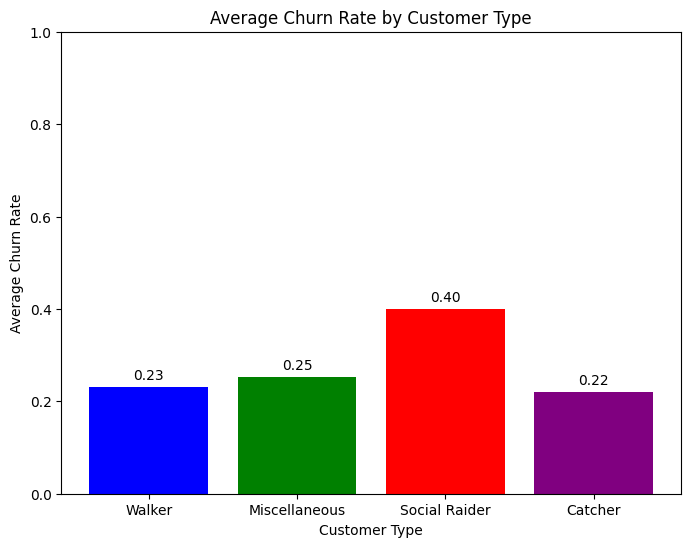

In [ ]:
# Calculate Average Churn for Eaach segment
walker = update_basetable[update_basetable["CustomerType"]==0]
miscellaneous = update_basetable[update_basetable["CustomerType"]==1]
social_raider = update_basetable[update_basetable["CustomerType"]==2]
catcher = update_basetable[update_basetable["CustomerType"]==3] #they don't churn

# Calculate Average churn rate
walker_churn_rate = np.mean(walker["churn"])
miscellaneous_churn_rate = np.mean(miscellaneous["churn"])
social_raider_churn_rate = np.mean(social_raider["churn"])
catcher_churn_rate = np.mean(catcher["churn"])

# Create Bar Graph with Data Labels
customer_types = ['Walker', 'Miscellaneous', 'Social Raider', 'Catcher']
churn_rates = [walker_churn_rate, miscellaneous_churn_rate, social_raider_churn_rate, catcher_churn_rate]

print("Catcher churn rate:", round(catcher_churn_rate*100,2),"%")
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(customer_types, churn_rates, color=['blue', 'green', 'red', 'purple'])

# Add data labels
for bar, rate in zip(bars, churn_rates):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
            f'{rate:.2f}', ha='center', va='bottom')

ax.set_title('Average Churn Rate by Customer Type')
ax.set_xlabel('Customer Type')
ax.set_ylabel('Average Churn Rate')
ax.set_ylim(0, 1)  # Set y-axis limits for better visualization
plt.show()

In [ ]:
# Group by customer type and aggregate statistics
customer_type_stats = update_basetable.groupby('CustomerType').agg(
    mean_churn=('churn', 'mean'),
    avg_clv=('CLV', 'mean'),
    customer_count=('CustomerID', 'count'),  # Count of customers in each type
    fallbonus_count=('fallbonus', lambda x: (x == 1).sum())  # Count fallbonus = 1
)

# Calculate the percentage of customers with fall bonus for each type
customer_type_stats['fallbonus_percentage'] = (customer_type_stats['fallbonus_count'] / customer_type_stats['customer_count']) * 100

# Rename columns for better readability
customer_type_stats = customer_type_stats.rename(
    columns={
        'mean_churn': 'Mean Churn Rate',
        'avg_clv': 'Average CLV',
        'customer_count': 'Customer Count',
        'fallbonus_count': 'Fall Bonus Count (fallbonus=1)',
        'fallbonus_percentage': 'Fall Bonus Percentage'
    }
)
customer_type_stats.head()

,Mean Churn Rate,Average CLV,Customer Count,Fall Bonus Count (fallbonus=1),Fall Bonus Percentage
CustomerType,,,,,
0,0.230844,78.152178,3106,628,20.218931
1,0.252134,79.407068,2812,547,19.452347
2,0.399154,121.241256,7090,1463,20.634697
3,0.220086,89.714382,4162,807,19.389716


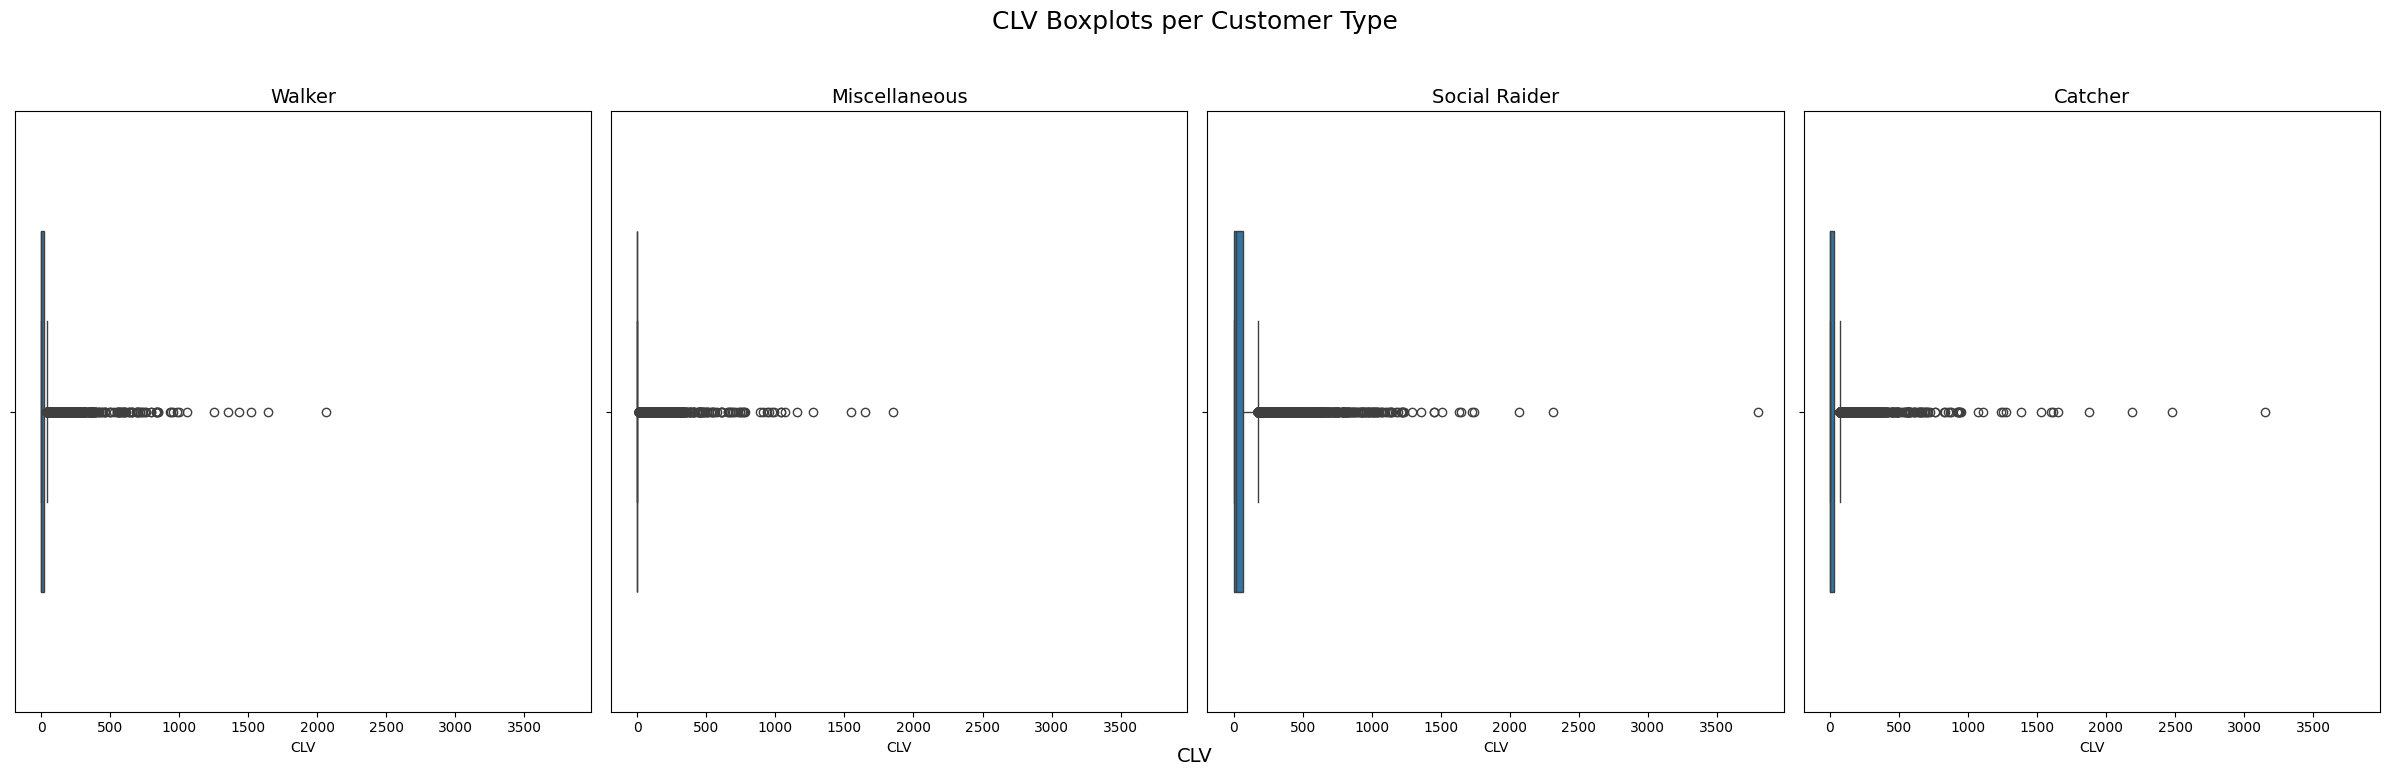

In [ ]:
# Box Plots of CLV for Customer Type to understand Outliers and Distribution
# Create subplots with increased figure size
fig, axes = plt.subplots(1, 4, figsize=(24, 8), sharex=True)  # Increased width

# Define customer types
customer_types = ['Walker', 'Miscellaneous', 'Social Raider', 'Catcher']

# Plot individual horizontal boxplots with increased box width
box_width = 0.6  # Adjust as needed
for i, customer_type in enumerate(customer_types):
    sns.boxplot(x='CLV', data=customer_profile[customer_profile['CustomerType'] == i],
                ax=axes[i], width=box_width, orient='h')  # Orient to horizontal
    axes[i].set_title(customer_type, fontsize=14)  # Increased title font size
    axes[i].set_ylabel('')  # Remove y-axis label for individual plots

# Set common x-axis label
fig.text(0.5, 0.04, 'CLV', ha='center', fontsize=14)  # Increased label font size

plt.suptitle('CLV Boxplots per Customer Type', fontsize=18)  # Increased title font size
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for title
plt.show()

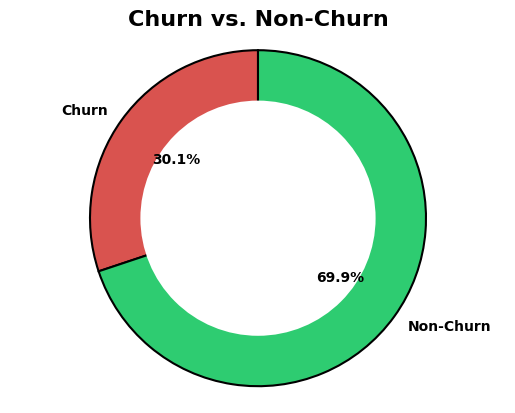

In [ ]:
#Show churn percentage visually
# Calculate churn and non-churn percentages
churn_rate = np.mean(update_basetable["churn"])
non_churn_rate = 1 - churn_rate

# Create labels and data
labels = ['Churn', 'Non-Churn']
sizes = [churn_rate, non_churn_rate]

# Create the donut chart with updated colors
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#d9534f', '#2ecc71'],  # Reddish-orange and green
    textprops={'weight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)


# Make percentage labels bold
for autotext in autotexts:
    autotext.set_weight('bold')

# Increase title size and font
plt.title('Churn vs. Non-Churn', fontsize=16, fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

# Add a circle at the center to create the donut hole
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.show()

## Question 3 | Part3 : Churn Prediction

In [ ]:
update_basetable.columns

Index(['CustomerID', 'frequency', 'recency', 'monetary', 'Age', 'Gender',
       'Income', 'CustomerType', 'males', 'females', 'low_income',
       'medium_income', 'high_income', 'avg_monthly_revenue', 'retention_rate',
       'CLV', 'Engagement', 'Frequency Group', 'Spender Group',
       'Lifecycle Segment', 'Spender Type', 'Engagement Segment',
       'Spending Segment', 'Exploration Segment', 'fallbonus',
       'average_experience', 'average_social', 'average_pokemons',
       'average_distance', 'average_duration', 'average_pokestops',
       'average_gym', 'average_raids', 'value', 'churn'],
      dtype='object')

In [ ]:
#Remove non-significant variables from our basetable
update_basetable_lr = update_basetable.drop(["CustomerID","Gender","Income",'males','medium_income','avg_monthly_revenue','Engagement', 'Frequency Group', 'Spender Group', 'Lifecycle Segment',
       'Spender Type', 'Engagement Segment', 'Spending Segment',
       'Exploration Segment', 'value'], axis=1)

In [ ]:
update_basetable_lr.columns

Index(['frequency', 'recency', 'monetary', 'Age', 'CustomerType', 'females',
       'low_income', 'high_income', 'retention_rate', 'CLV', 'fallbonus',
       'average_experience', 'average_social', 'average_pokemons',
       'average_distance', 'average_duration', 'average_pokestops',
       'average_gym', 'average_raids', 'churn'],
      dtype='object')

In [ ]:
update_basetable_lr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17170 entries, 0 to 17169
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   frequency           17170 non-null  int64  
 1   recency             17170 non-null  int64  
 2   monetary            17170 non-null  float64
 3   Age                 17170 non-null  int64  
 4   CustomerType        17170 non-null  int64  
 5   females             17170 non-null  int64  
 6   low_income          17170 non-null  int64  
 7   high_income         17170 non-null  int64  
 8   retention_rate      17170 non-null  float64
 9   CLV                 17170 non-null  float64
 10  fallbonus           17170 non-null  int64  
 11  average_experience  17170 non-null  float64
 12  average_social      17170 non-null  float64
 13  average_pokemons    17170 non-null  float64
 14  average_distance    17170 non-null  float64
 15  average_duration    17170 non-null  float64
 16  aver

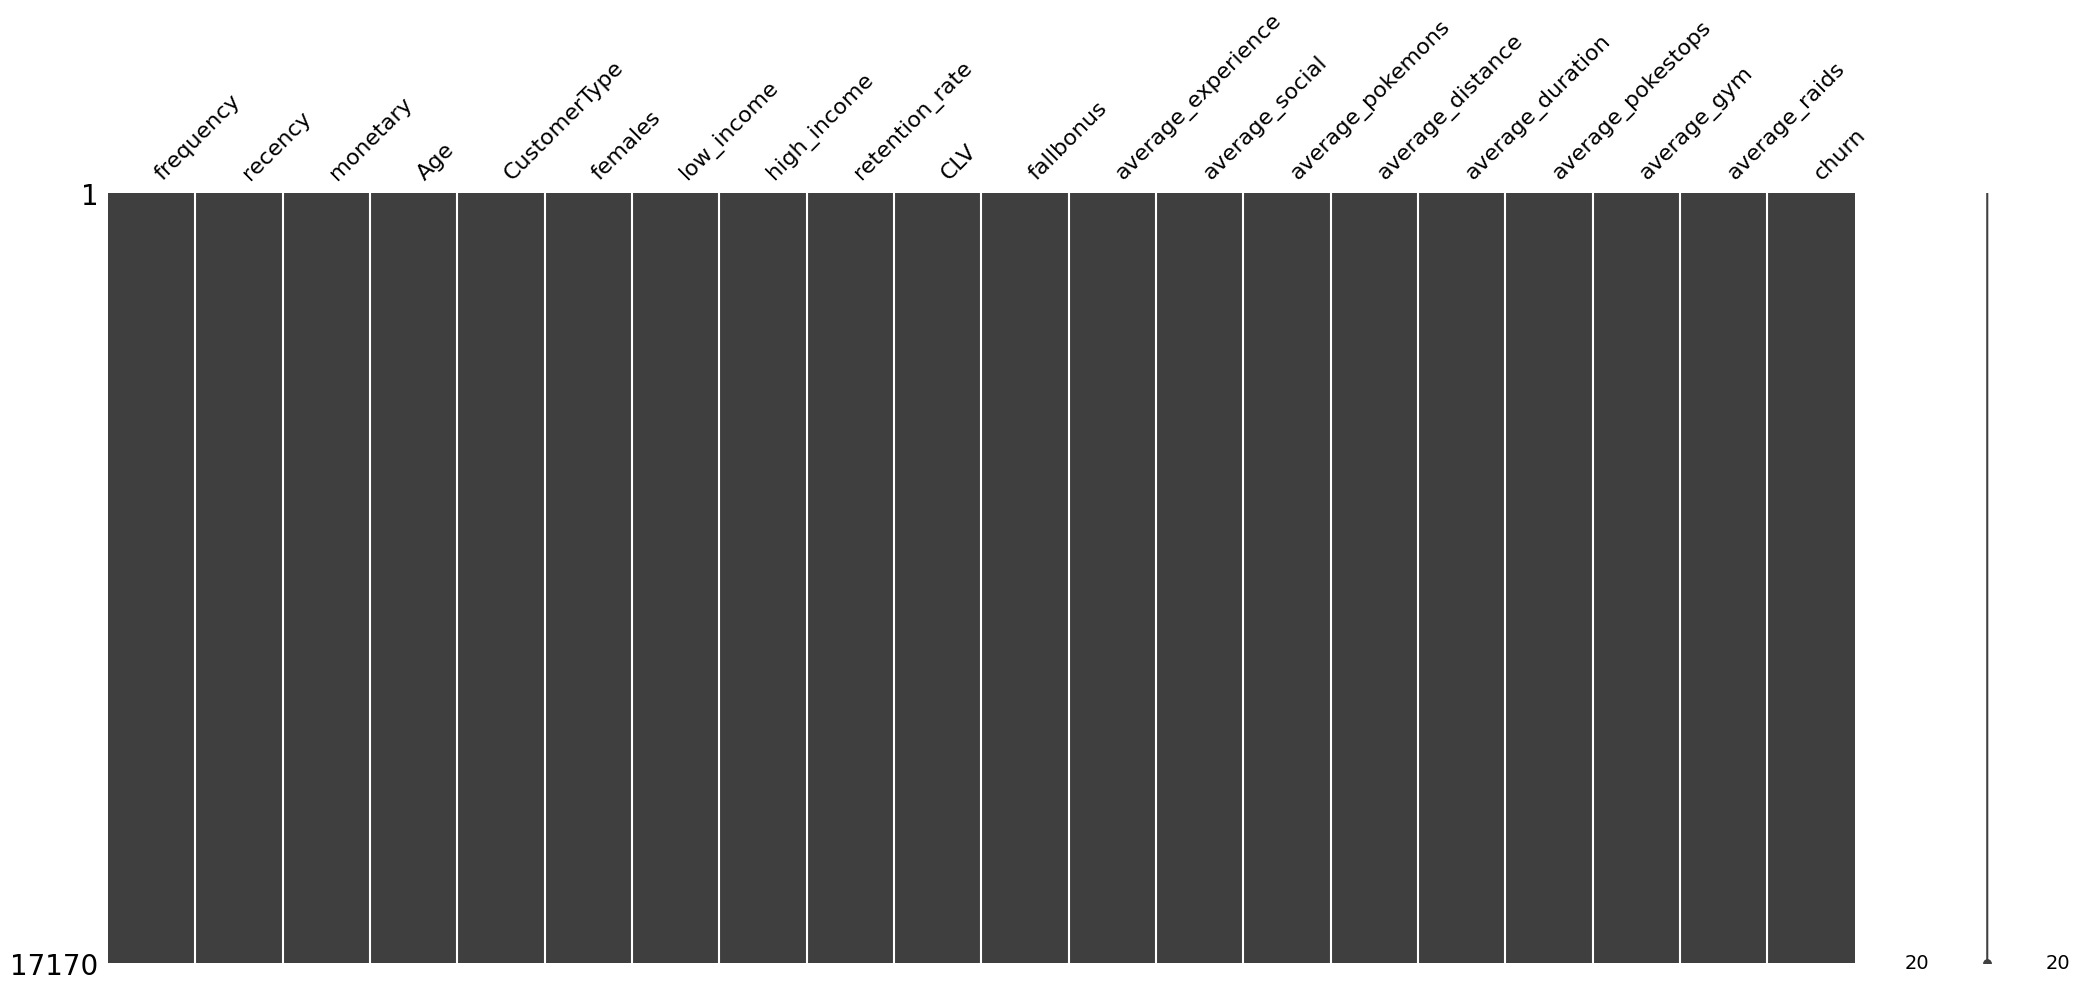

In [ ]:
# Checking for missing values
missingno.matrix(update_basetable_lr)
plt.show()

In [ ]:
update_basetable_lr.columns

Index(['frequency', 'recency', 'monetary', 'Age', 'CustomerType', 'females',
       'low_income', 'high_income', 'retention_rate', 'CLV', 'fallbonus',
       'average_experience', 'average_social', 'average_pokemons',
       'average_distance', 'average_duration', 'average_pokestops',
       'average_gym', 'average_raids', 'churn'],
      dtype='object')

In [ ]:
update_basetable_lr['fallbonus'].unique()

array([0, 1])

In [ ]:
# Standardization of the variables which are not between O and 1
from sklearn.preprocessing import StandardScaler

# Select the columns to standardize
columns_to_standardize = ['recency', 'frequency', 'monetary', 'average_experience', 'average_social','CLV',
                          'average_pokemons', 'average_distance', 'average_duration',
                          'average_pokestops', 'average_gym', 'average_raids']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the selected columns
update_basetable_lr[columns_to_standardize] = scaler.fit_transform(update_basetable_lr[columns_to_standardize])

# Now the specified columns in update_basetable_lr are standardized.
update_basetable_lr.head()


,frequency,recency,monetary,Age,CustomerType,females,low_income,high_income,retention_rate,CLV,fallbonus,average_experience,average_social,average_pokemons,average_distance,average_duration,average_pokestops,average_gym,average_raids,churn
0,0.249454,-0.239673,-0.420731,18,3,1,0,1,0.746194,-0.474420,0,0.077401,-0.842150,2.498760,-0.619712,-1.016793,0.754239,-0.222708,-0.884160,0
1,-0.724316,1.706962,-0.548868,35,3,0,0,1,0.784649,-0.503920,1,-0.300673,-0.810346,1.925485,-0.574982,-1.184837,1.022459,-0.458759,-0.884160,0
2,-2.184970,2.231057,-0.420731,15,3,1,0,1,0.789557,-0.134249,1,-0.432476,-0.953464,1.925485,-0.286906,-1.203497,0.959595,-0.748458,-0.884160,0
3,0.736339,0.808515,1.501324,12,2,0,1,0,0.724825,0.602313,0,0.057310,0.749635,-0.786547,-0.612694,0.881300,-1.346255,0.693600,0.352648,0
4,0.736339,3.503857,-0.100388,31,0,0,1,0,0.761677,-0.282127,0,-0.448422,-0.753099,-0.098617,2.337832,0.058707,1.258827,-0.748458,-0.884160,1


<Axes: >

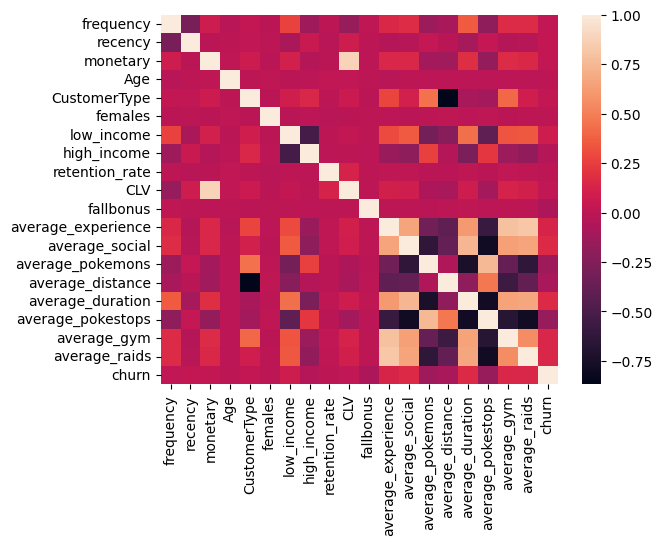

In [ ]:
# within sample creation
train, test = train_test_split(update_basetable_lr, test_size=0.3,random_state=1)


# Exploratory analysis
corrmatrixtrain=train.corr()
corrmatrixtest=test.corr()
sns.heatmap(train.corr())


# **Choice of the model**

### **Logistic regression**

Optimization terminated successfully.
         Current function value: 0.589181
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                12019
Model:                          Logit   Df Residuals:                    11999
Method:                           MLE   Df Model:                           19
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                 0.03204
Time:                        18:50:20   Log-Likelihood:                -7081.4
converged:                       True   LL-Null:                       -7315.8
Covariance Type:            nonrobust   LLR p-value:                 1.917e-87
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.0541      0.330     -3.197      0.001      -1.700      -0.408
freq

<ipython-input-38-dbad5ad8c68b>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



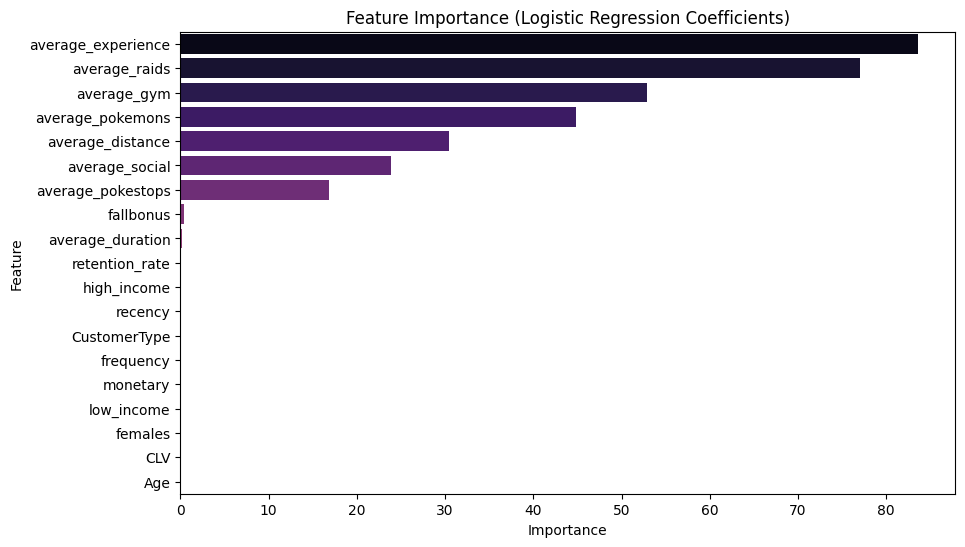


--- Train Set Evaluation ---


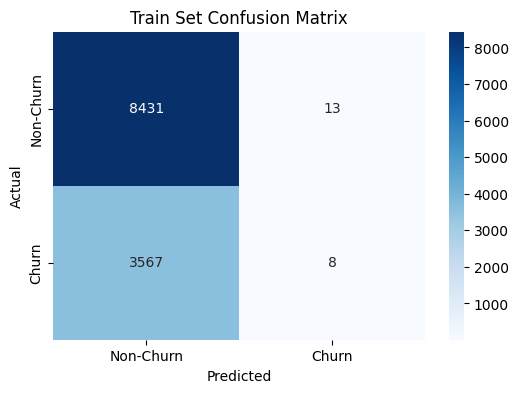

Accuracy: 0.7021382810549962
Precision: 0.38095238095238093
F1-Score: 0.004449388209121246
Sensitivity (Recall): 0.0022377622377622378
Specificity: 0.9984604452865941

--- Test Set Evaluation ---


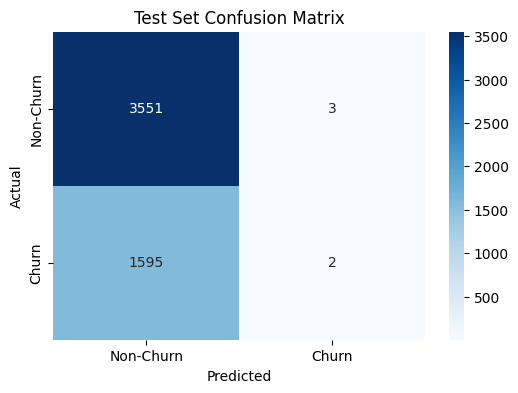

Accuracy: 0.6897689768976898
Precision: 0.4
F1-Score: 0.0024968789013732834
Sensitivity (Recall): 0.0012523481527864746
Specificity: 0.9991558806978053


In [ ]:
# Model building
logit_mod = smf.logit(formula='churn ~ frequency+recency+monetary+Age+females+low_income+high_income+retention_rate+CLV+fallbonus+CustomerType+average_experience+average_social+average_pokemons+average_distance+average_duration+average_pokestops+average_gym+average_raids', data=train)

logit_res = logit_mod.fit()
print(logit_res.summary())

# Feature Importance (using coefficients)
feature_df = pd.DataFrame({
    'Feature': logit_res.params.index,
    'Coefficient': logit_res.params.values
})

# Calculate Importance as the absolute value of coefficients
feature_df['Importance'] = feature_df['Coefficient'].abs()
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Filter out the intercept before plotting
feature_df_filtered = feature_df[feature_df['Feature'] != 'Intercept']


# Plot Feature Importance with different colors for each feature
plt.figure(figsize=(10, 6))

# Use a color palette that assigns different colors to each bar
sns.barplot(x='Importance', y='Feature', data=feature_df_filtered, palette='magma')

plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

# Predict on train and test sets
train_predictions = logit_res.predict(train)
test_predictions = logit_res.predict(test)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
train_predictions_binary = (train_predictions >= 0.5).astype(int)
test_predictions_binary = (test_predictions >= 0.5).astype(int)

# --- Evaluation Metrics ---
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Train Set Evaluation ---
print("\n--- Train Set Evaluation ---")

# Confusion Matrix
train_conf_matrix = confusion_matrix(train['churn'], train_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Train Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
train_accuracy = accuracy_score(train['churn'], train_predictions_binary)
print("Accuracy:", train_accuracy)

# Precision
train_precision = precision_score(train['churn'], train_predictions_binary)
print("Precision:", train_precision)

# F1-Score
train_f1 = f1_score(train['churn'], train_predictions_binary)
print("F1-Score:", train_f1)


# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = train_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# --- Test Set Evaluation ---
print("\n--- Test Set Evaluation ---")

# Confusion Matrix
test_conf_matrix = confusion_matrix(test['churn'], test_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
test_accuracy = accuracy_score(test['churn'], test_predictions_binary)
print("Accuracy:", test_accuracy)

# Precision
test_precision = precision_score(test['churn'], test_predictions_binary)
print("Precision:", test_precision)

# F1-Score
test_f1 = f1_score(test['churn'], test_predictions_binary)
print("F1-Score:", test_f1)

# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = test_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)



### **Random Forest classifier**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
#np.random.sample(42)
# Assuming 'update_basetable_lr' is your DataFrame with features and 'churn' as the target variable
# Select features and target variable
#df=update_basetable_lr.sample(n=5000, random_state=42)
X = update_basetable_lr[['frequency', 'recency', 'monetary', 'Age', 'females', 'low_income', 'high_income',
                        'retention_rate', 'CLV', 'fallbonus',"CustomerType","average_experience","average_social","average_pokemons","average_distance","average_duration","average_pokestops","average_gym","average_raids"]]

y = update_basetable_lr['churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(bootstrap=True, random_state=42)
rf_model.fit(X_train, y_train)

# Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature average_duration (0.087579)
2. feature average_distance (0.082720)
3. feature average_experience (0.081732)
4. feature retention_rate (0.081403)
5. feature average_pokestops (0.081042)
6. feature average_pokemons (0.080652)
7. feature CLV (0.077852)
8. feature average_gym (0.076395)
9. feature Age (0.065801)
10. feature recency (0.065467)
11. feature average_social (0.063367)
12. feature average_raids (0.045958)
13. feature frequency (0.034803)
14. feature monetary (0.033812)
15. feature females (0.011079)
16. feature low_income (0.010017)
17. feature fallbonus (0.008629)
18. feature high_income (0.008300)
19. feature CustomerType (0.003390)


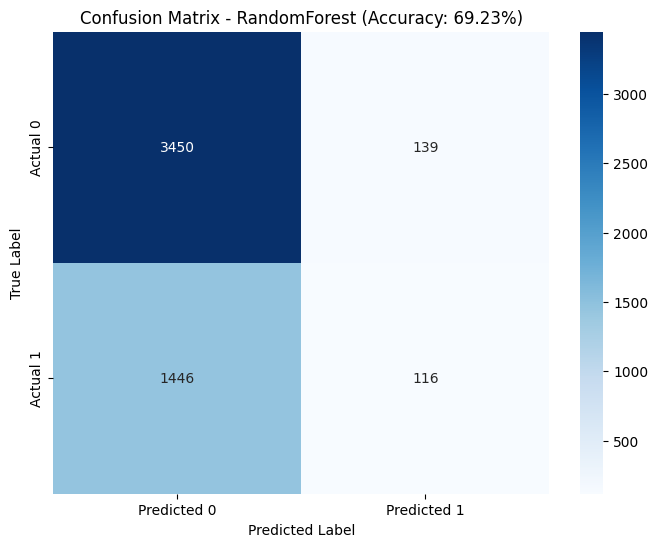

In [ ]:
# Confusion Performance Matrix RandomForest
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)*100
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Confusion Matrix - RandomForest (Accuracy: {accuracy:.2f}%)')  # Include accuracy
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### **XGBOOST Classifier**

In [ ]:
from xgboost import XGBClassifier

# Create and train the XGBoost model
xgb_model = XGBClassifier(random_state=42)  # You can adjust hyperparameters here
xgb_model.fit(X_train, y_train)

# Feature Importance
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature fallbonus (0.098054)
2. feature average_pokestops (0.083375)
3. feature low_income (0.059427)
4. feature females (0.054793)
5. feature average_distance (0.053730)
6. feature average_experience (0.051698)
7. feature average_gym (0.050193)
8. feature average_pokemons (0.049716)
9. feature CLV (0.049097)
10. feature average_duration (0.048662)
11. feature retention_rate (0.048609)
12. feature Age (0.048234)
13. feature recency (0.048001)
14. feature frequency (0.047647)
15. feature average_raids (0.046527)
16. feature high_income (0.046396)
17. feature average_social (0.046094)
18. feature monetary (0.045995)
19. feature CustomerType (0.023753)


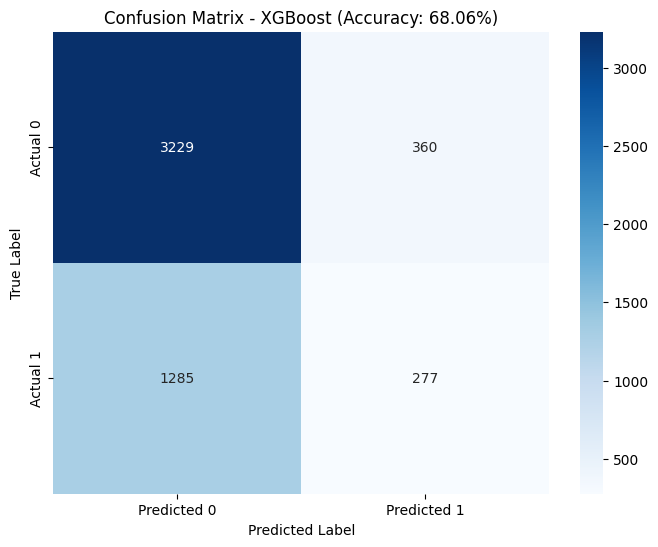

In [ ]:
# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb) * 100

# Create confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Confusion Matrix - XGBoost (Accuracy: {accuracy_xgb:.2f}%)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

We selected logistic regression as our final model because it achieved the highest accuracy (70.24%) compared to the random forest classifier (69.46%) and the XGBoost classifier (67.33%). In addition to its competitive performance, logistic regression is also simpler to interpret, making it easier to understand the impact of individual features on churn. Unlike tree-based models, which can be complex and difficult to explain, logistic regression provides clear coefficients that indicate how each variable influences the likelihood of churn.

### **Final logistic regression model**

Based on the logistic model output, we will build a final logistic regression model using only the significant variables: recency, fall bonus, and average duration, as they are key predictors of customer churn to improve our accuracy.

Optimization terminated successfully.
         Current function value: 0.512704
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 2913
Model:                          Logit   Df Residuals:                     2909
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                0.003555
Time:                        18:55:40   Log-Likelihood:                -1493.5
converged:                       True   LL-Null:                       -1498.8
Covariance Type:            nonrobust   LLR p-value:                   0.01373
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.6927      0.455     -1.522      0.128      -1.584       0.199
recency    

<ipython-input-55-b3b2a0d7eec7>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



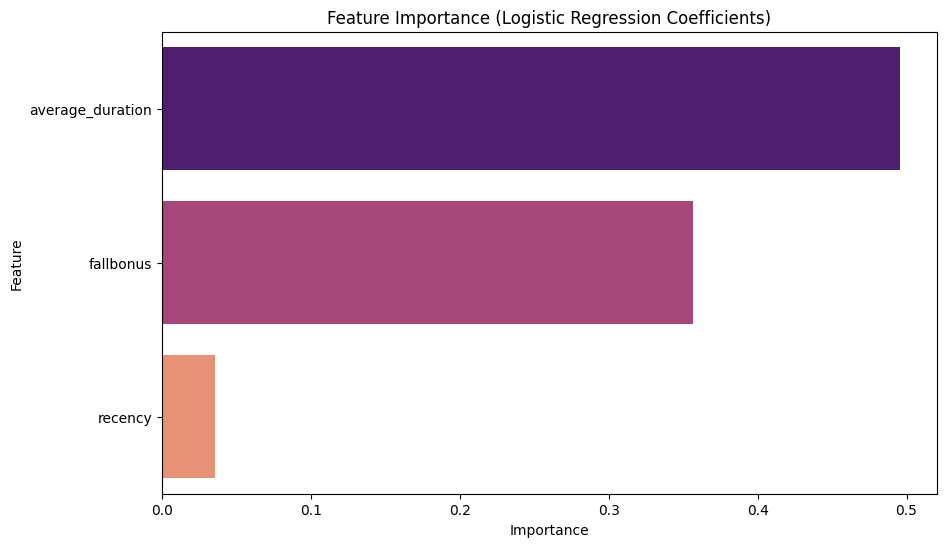


--- Train Set Evaluation ---


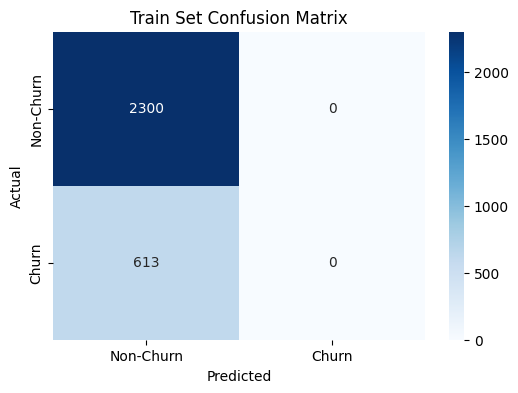

Accuracy: 0.789564023343632
Precision: 0.0
F1-Score: 0.0
Sensitivity (Recall): 0.0
Specificity: 1.0

--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


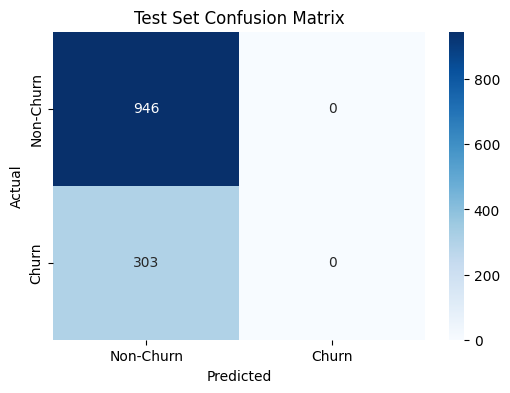

Accuracy: 0.7574059247397918
Precision: 0.0
F1-Score: 0.0
Sensitivity (Recall): 0.0
Specificity: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
# Model building
logit_mod2 = smf.logit(formula='churn ~ recency+fallbonus+average_duration', data=train)

logit_res2 = logit_mod2.fit()
print(logit_res2.summary())

# Feature Importance (using coefficients)
feature_df2 = pd.DataFrame({
    'Feature': logit_res2.params.index,
    'Coefficient': logit_res2.params.values
})

# Calculate Importance as the absolute value of coefficients
feature_df2['Importance'] = feature_df2['Coefficient'].abs()
feature_df2 = feature_df2.sort_values(by='Importance', ascending=False)

# Filter out the intercept before plotting
feature_df_filtered2 = feature_df2[feature_df2['Feature'] != 'Intercept']


# Plot Feature Importance with different colors for each feature
plt.figure(figsize=(10, 6))

# Use a color palette that assigns different colors to each bar
sns.barplot(x='Importance', y='Feature', data=feature_df_filtered2, palette='magma')

plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

# Predict on train and test sets
train_predictions2 = logit_res2.predict(train)
test_predictions2 = logit_res2.predict(test)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
train_predictions_binary2 = (train_predictions2 >= 0.5).astype(int)
test_predictions_binary2 = (test_predictions2 >= 0.5).astype(int)

# --- Evaluation Metrics ---
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Train Set Evaluation ---
print("\n--- Train Set Evaluation ---")

# Confusion Matrix
train_conf_matrix2 = confusion_matrix(train['churn'], train_predictions_binary2)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(train_conf_matrix2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Train Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
train_accuracy2 = accuracy_score(train['churn'], train_predictions_binary2)
print("Accuracy:", train_accuracy2)

# Precision
train_precision2 = precision_score(train['churn'], train_predictions_binary2)
print("Precision:", train_precision2)

# F1-Score
train_f1_2 = f1_score(train['churn'], train_predictions_binary2)
print("F1-Score:", train_f1_2)


# Calculate Sensitivity (Recall) and Specificity
TN2, FP2, FN2, TP2 = train_conf_matrix2.ravel()  # Extract values from confusion matrix
sensitivity2 = TP2 / (TP2 + FN2)  # Sensitivity = Recall
specificity2 = TN2 / (TN2 + FP2)

print("Sensitivity (Recall):", sensitivity2)
print("Specificity:", specificity2)

# --- Test Set Evaluation ---
print("\n--- Test Set Evaluation ---")

# Confusion Matrix
test_conf_matrix2 = confusion_matrix(test['churn'], test_predictions_binary2)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
test_accuracy2 = accuracy_score(test['churn'], test_predictions_binary2)
print("Accuracy:", test_accuracy2)

# Precision
test_precision2 = precision_score(test['churn'], test_predictions_binary2)
print("Precision:", test_precision2)

# F1-Score
test_f1_2 = f1_score(test['churn'], test_predictions_binary2)
print("F1-Score:", test_f1_2)

# Calculate Sensitivity (Recall) and Specificity
TN2, FP2, FN2, TP2 = test_conf_matrix2.ravel()  # Extract values from confusion matrix
sensitivity2 = TP2 / (TP2 + FN2)  # Sensitivity = Recall
specificity2 = TN2 / (TN2 + FP2)

print("Sensitivity (Recall):", sensitivity2)
print("Specificity:", specificity2)


## **Churn prediction for each segment**

In [ ]:
# Create logistic regression basetable for each segment
walker_lr = update_basetable_lr[update_basetable_lr["CustomerType"]==0]
miscellaneous_lr = update_basetable_lr[update_basetable_lr["CustomerType"]==1]
social_raider_lr = update_basetable_lr[update_basetable_lr["CustomerType"]==2]
catcher_lr = update_basetable_lr[update_basetable_lr["CustomerType"]==3]

In [ ]:
walker_lr

,frequency,recency,monetary,Age,CustomerType,females,low_income,high_income,retention_rate,CLV,fallbonus,average_experience,average_social,average_pokemons,average_distance,average_duration,average_pokestops,average_gym,average_raids,churn
4,0.736339,3.503857,-0.100388,31,0,0,1,0,0.761677,-0.282127,0,-0.448422,-0.753099,-0.098617,2.337832,0.058707,1.258827,-0.748458,-0.884160,1
6,1.710109,-0.688897,-0.548868,9,0,1,1,0,0.817980,-0.569279,1,0.015308,-0.369067,0.249758,2.816609,0.184954,1.106277,-0.710904,-0.884160,0
10,0.249454,-0.763767,-0.100388,33,0,0,0,0,0.858384,-0.054372,0,-0.519011,-0.730837,-0.117726,1.370154,-0.023250,0.715124,-0.122565,-0.884160,0
18,0.249454,-0.089932,-0.100388,11,0,0,1,0,0.868082,-0.027713,0,-0.712014,-0.842150,-0.103027,1.253218,0.251127,0.871585,-0.372922,-0.884160,1
19,-0.724316,0.134680,-0.548868,28,0,0,0,0,0.840315,-0.463628,0,-0.544142,-0.810346,0.375752,2.332308,-0.246833,1.123041,-1.231289,-0.884160,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17154,-2.671855,1.107998,-0.548868,46,0,0,1,0,0.794992,-0.238433,1,-1.142950,-0.953464,-0.588106,1.786083,0.004984,1.106277,-0.973779,-0.884160,0
17157,0.736339,1.257739,-0.548868,11,0,1,0,0,0.756326,-0.571152,0,-0.564177,-0.552735,0.033677,2.313232,-0.213719,1.223623,-1.108972,-0.884160,0
17159,0.249454,-0.314544,0.861280,42,0,0,0,1,0.876260,1.030953,0,-1.022876,-0.953464,-0.161824,2.072563,0.379286,0.988931,-1.274207,-0.884160,0
17165,-1.698085,2.006445,-0.420731,13,0,0,0,0,0.707219,-0.339291,0,-0.496262,-0.753099,-0.111846,1.073334,-0.419564,1.505254,-0.162622,-0.884160,1


**Walkers**

Optimization terminated successfully.
         Current function value: 0.541932
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 2174
Model:                          Logit   Df Residuals:                     2155
Method:                           MLE   Df Model:                           18
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                0.005198
Time:                        18:50:28   Log-Likelihood:                -1178.2
converged:                       True   LL-Null:                       -1184.3
Covariance Type:            nonrobust   LLR p-value:                    0.8307
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.7447      1.319     -1.323      0.186      -4.329       0.840
freq

<ipython-input-47-4e649abbea85>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



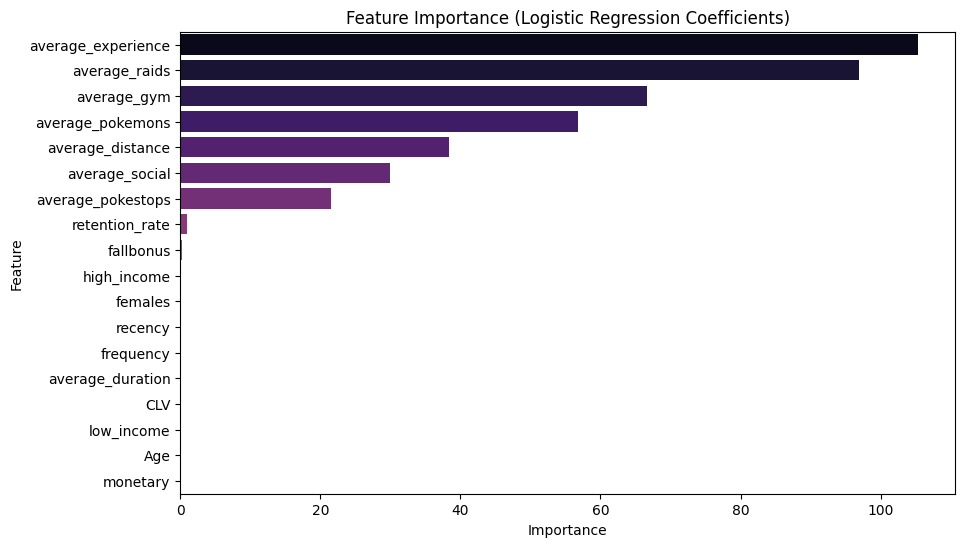


--- Train Set Evaluation ---


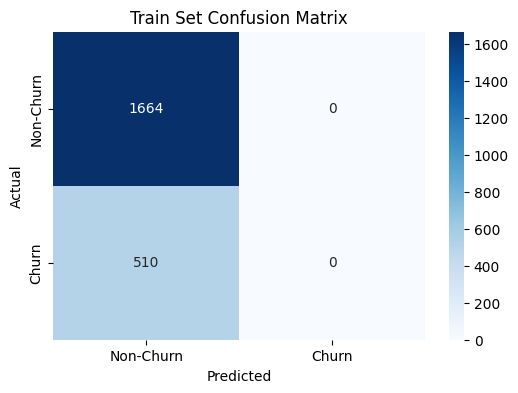

Accuracy: 0.765409383624655
Precision: 0.0
F1-Score: 0.0
Sensitivity (Recall): 0.0
Specificity: 1.0

--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


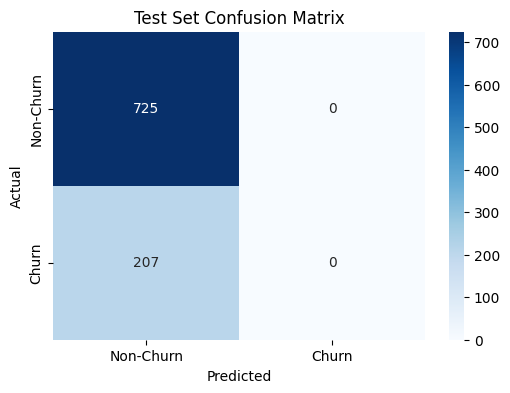

Accuracy: 0.7778969957081545
Precision: 0.0
F1-Score: 0.0
Sensitivity (Recall): 0.0
Specificity: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
# within sample creation
train, test = train_test_split(walker_lr, test_size=0.3,random_state=1)


# Model building
logit_mod = smf.logit(formula='churn ~ frequency+recency+monetary+Age+females+low_income+high_income+retention_rate+CLV+fallbonus+average_experience+average_social+average_pokemons+average_distance+average_duration+average_pokestops+average_gym+average_raids', data=train)

logit_res = logit_mod.fit()
print(logit_res.summary())

# Feature Importance (using coefficients)
feature_df = pd.DataFrame({
    'Feature': logit_res.params.index,
    'Coefficient': logit_res.params.values
})

# Calculate Importance as the absolute value of coefficients
feature_df['Importance'] = feature_df['Coefficient'].abs()
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Filter out the intercept before plotting
feature_df_filtered = feature_df[feature_df['Feature'] != 'Intercept']


# Plot Feature Importance with different colors for each feature
plt.figure(figsize=(10, 6))

# Use a color palette that assigns different colors to each bar
sns.barplot(x='Importance', y='Feature', data=feature_df_filtered, palette='magma')

plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

# Predict on train and test sets
train_predictions = logit_res.predict(train)
test_predictions = logit_res.predict(test)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
train_predictions_binary = (train_predictions >= 0.5).astype(int)
test_predictions_binary = (test_predictions >= 0.5).astype(int)

# --- Evaluation Metrics ---
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Train Set Evaluation ---
print("\n--- Train Set Evaluation ---")

# Confusion Matrix
train_conf_matrix = confusion_matrix(train['churn'], train_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Train Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
train_accuracy = accuracy_score(train['churn'], train_predictions_binary)
print("Accuracy:", train_accuracy)

# Precision
train_precision = precision_score(train['churn'], train_predictions_binary)
print("Precision:", train_precision)

# F1-Score
train_f1 = f1_score(train['churn'], train_predictions_binary)
print("F1-Score:", train_f1)


# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = train_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# --- Test Set Evaluation ---
print("\n--- Test Set Evaluation ---")

# Confusion Matrix
test_conf_matrix = confusion_matrix(test['churn'], test_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
test_accuracy = accuracy_score(test['churn'], test_predictions_binary)
print("Accuracy:", test_accuracy)

# Precision
test_precision = precision_score(test['churn'], test_predictions_binary)
print("Precision:", test_precision)

# F1-Score
test_f1 = f1_score(test['churn'], test_predictions_binary)
print("F1-Score:", test_f1)

# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = test_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)


Based on the logistic regression output for walkers, no variables were found to be significant in predicting churn.

### **Miscellaneous**

Optimization terminated successfully.
         Current function value: 0.560828
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 1968
Model:                          Logit   Df Residuals:                     1949
Method:                           MLE   Df Model:                           18
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                 0.01236
Time:                        18:50:28   Log-Likelihood:                -1103.7
converged:                       True   LL-Null:                       -1117.5
Covariance Type:            nonrobust   LLR p-value:                   0.06786
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.1317      0.854     -1.325      0.185      -2.805       0.542
frequ

<ipython-input-48-b90f91d61451>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



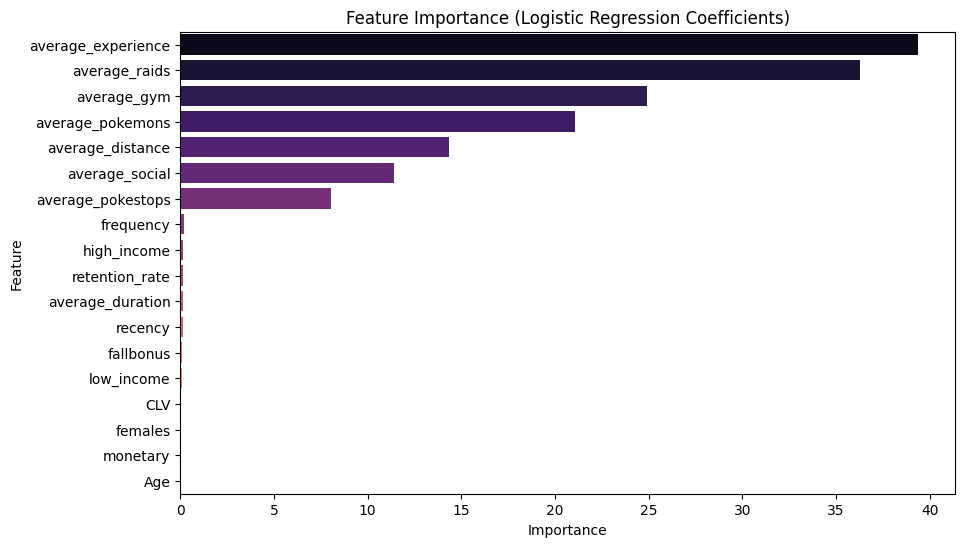


--- Train Set Evaluation ---


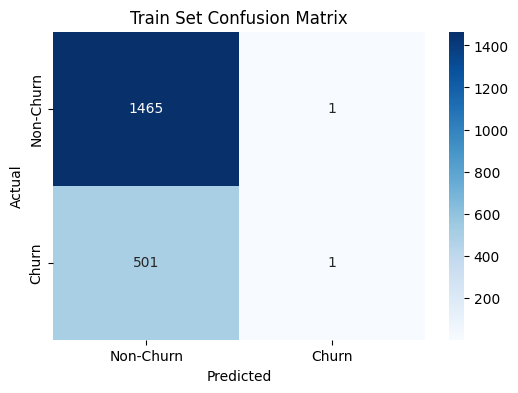

Accuracy: 0.7449186991869918
Precision: 0.5
F1-Score: 0.003968253968253968
Sensitivity (Recall): 0.00199203187250996
Specificity: 0.9993178717598908

--- Test Set Evaluation ---


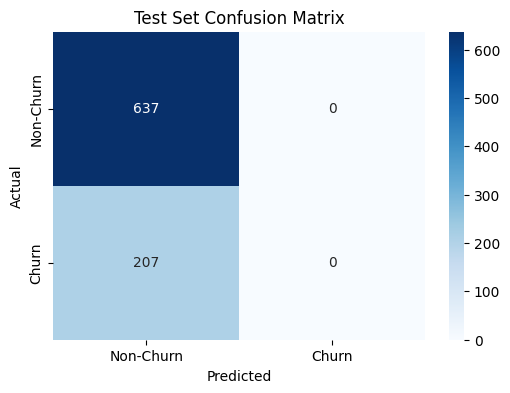

Accuracy: 0.754739336492891
Precision: 0.0
F1-Score: 0.0
Sensitivity (Recall): 0.0
Specificity: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
# within sample creation
train, test = train_test_split(miscellaneous_lr, test_size=0.3,random_state=1)


# Model building
logit_mod = smf.logit(formula='churn ~ frequency+recency+monetary+Age+females+low_income+high_income+retention_rate+CLV+fallbonus+average_experience+average_social+average_pokemons+average_distance+average_duration+average_pokestops+average_gym+average_raids', data=train)

logit_res = logit_mod.fit()
print(logit_res.summary())

# Feature Importance (using coefficients)
feature_df = pd.DataFrame({
    'Feature': logit_res.params.index,
    'Coefficient': logit_res.params.values
})

# Calculate Importance as the absolute value of coefficients
feature_df['Importance'] = feature_df['Coefficient'].abs()
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Filter out the intercept before plotting
feature_df_filtered = feature_df[feature_df['Feature'] != 'Intercept']


# Plot Feature Importance with different colors for each feature
plt.figure(figsize=(10, 6))

# Use a color palette that assigns different colors to each bar
sns.barplot(x='Importance', y='Feature', data=feature_df_filtered, palette='magma')

plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

# Predict on train and test sets
train_predictions = logit_res.predict(train)
test_predictions = logit_res.predict(test)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
train_predictions_binary = (train_predictions >= 0.5).astype(int)
test_predictions_binary = (test_predictions >= 0.5).astype(int)

# --- Evaluation Metrics ---
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Train Set Evaluation ---
print("\n--- Train Set Evaluation ---")

# Confusion Matrix
train_conf_matrix = confusion_matrix(train['churn'], train_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Train Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
train_accuracy = accuracy_score(train['churn'], train_predictions_binary)
print("Accuracy:", train_accuracy)

# Precision
train_precision = precision_score(train['churn'], train_predictions_binary)
print("Precision:", train_precision)

# F1-Score
train_f1 = f1_score(train['churn'], train_predictions_binary)
print("F1-Score:", train_f1)


# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = train_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# --- Test Set Evaluation ---
print("\n--- Test Set Evaluation ---")

# Confusion Matrix
test_conf_matrix = confusion_matrix(test['churn'], test_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
test_accuracy = accuracy_score(test['churn'], test_predictions_binary)
print("Accuracy:", test_accuracy)

# Precision
test_precision = precision_score(test['churn'], test_predictions_binary)
print("Precision:", test_precision)

# F1-Score
test_f1 = f1_score(test['churn'], test_predictions_binary)
print("F1-Score:", test_f1)

# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = test_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)


Based on the logistic regression output for the Miscellaneous segment, only frequency and recency are significant predictors of churn. Therefore, we will include only these variables in our final model to enhance accuracy.

**Miscellaneous final model**

Optimization terminated successfully.
         Current function value: 0.562203
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 1968
Model:                          Logit   Df Residuals:                     1965
Method:                           MLE   Df Model:                            2
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                0.009943
Time:                        18:50:29   Log-Likelihood:                -1106.4
converged:                       True   LL-Null:                       -1117.5
Covariance Type:            nonrobust   LLR p-value:                 1.494e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1179      0.054    -20.869      0.000      -1.223      -1.013
frequency     -0.1467      0.

<ipython-input-49-8931d2dcc85a>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



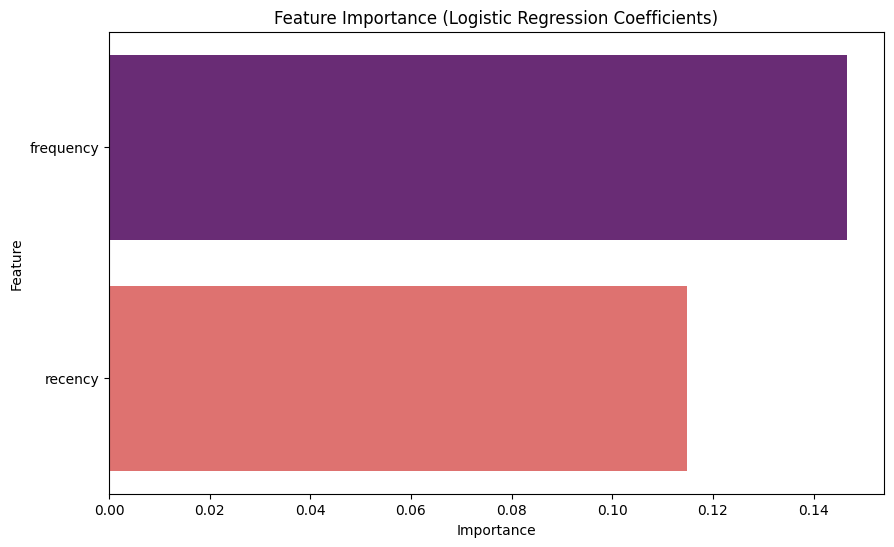


--- Train Set Evaluation ---


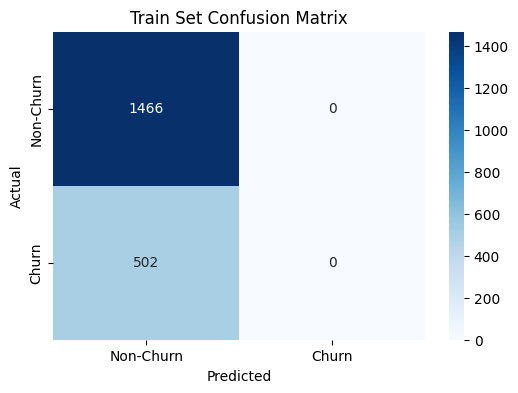

Accuracy: 0.7449186991869918
Precision: 0.0
F1-Score: 0.0
Sensitivity (Recall): 0.0
Specificity: 1.0

--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


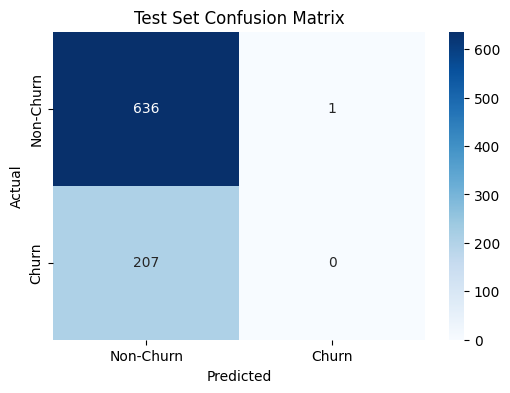

Accuracy: 0.7535545023696683
Precision: 0.0
F1-Score: 0.0
Sensitivity (Recall): 0.0
Specificity: 0.9984301412872841


In [ ]:
# within sample creation
train, test = train_test_split(miscellaneous_lr, test_size=0.3,random_state=1)


# Model building
logit_mod = smf.logit(formula='churn ~ frequency+recency', data=train)

logit_res = logit_mod.fit()
print(logit_res.summary())

# Feature Importance (using coefficients)
feature_df = pd.DataFrame({
    'Feature': logit_res.params.index,
    'Coefficient': logit_res.params.values
})

# Calculate Importance as the absolute value of coefficients
feature_df['Importance'] = feature_df['Coefficient'].abs()
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Filter out the intercept before plotting
feature_df_filtered = feature_df[feature_df['Feature'] != 'Intercept']


# Plot Feature Importance with different colors for each feature
plt.figure(figsize=(10, 6))

# Use a color palette that assigns different colors to each bar
sns.barplot(x='Importance', y='Feature', data=feature_df_filtered, palette='magma')

plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

# Predict on train and test sets
train_predictions = logit_res.predict(train)
test_predictions = logit_res.predict(test)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
train_predictions_binary = (train_predictions >= 0.5).astype(int)
test_predictions_binary = (test_predictions >= 0.5).astype(int)

# --- Evaluation Metrics ---
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Train Set Evaluation ---
print("\n--- Train Set Evaluation ---")

# Confusion Matrix
train_conf_matrix = confusion_matrix(train['churn'], train_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Train Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
train_accuracy = accuracy_score(train['churn'], train_predictions_binary)
print("Accuracy:", train_accuracy)

# Precision
train_precision = precision_score(train['churn'], train_predictions_binary)
print("Precision:", train_precision)

# F1-Score
train_f1 = f1_score(train['churn'], train_predictions_binary)
print("F1-Score:", train_f1)


# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = train_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# --- Test Set Evaluation ---
print("\n--- Test Set Evaluation ---")

# Confusion Matrix
test_conf_matrix = confusion_matrix(test['churn'], test_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
test_accuracy = accuracy_score(test['churn'], test_predictions_binary)
print("Accuracy:", test_accuracy)

# Precision
test_precision = precision_score(test['churn'], test_predictions_binary)
print("Precision:", test_precision)

# F1-Score
test_f1 = f1_score(test['churn'], test_predictions_binary)
print("F1-Score:", test_f1)

# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = test_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)


### **Social raiders**

Optimization terminated successfully.
         Current function value: 0.661523
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 4963
Model:                          Logit   Df Residuals:                     4944
Method:                           MLE   Df Model:                           18
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                 0.01559
Time:                        18:50:30   Log-Likelihood:                -3283.1
converged:                       True   LL-Null:                       -3335.1
Covariance Type:            nonrobust   LLR p-value:                 4.041e-14
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.3276      0.539     -0.608      0.543      -1.383       0.728
frequ

<ipython-input-50-6023865dac7a>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



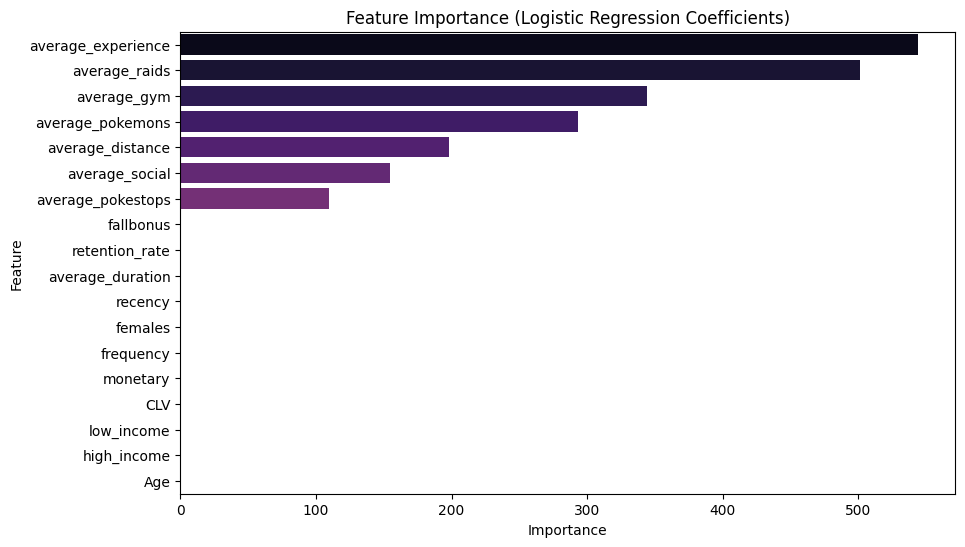


--- Train Set Evaluation ---


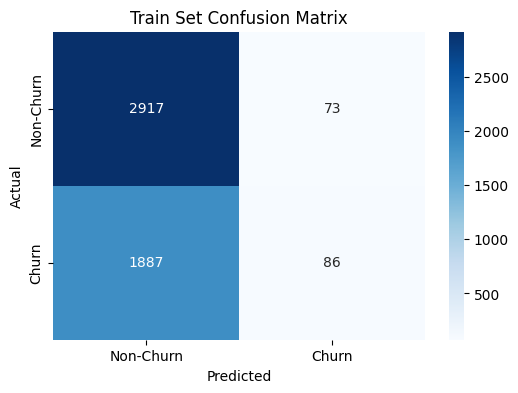

Accuracy: 0.6050775740479548
Precision: 0.5408805031446541
F1-Score: 0.08067542213883677
Sensitivity (Recall): 0.04358844399391789
Specificity: 0.9755852842809365

--- Test Set Evaluation ---


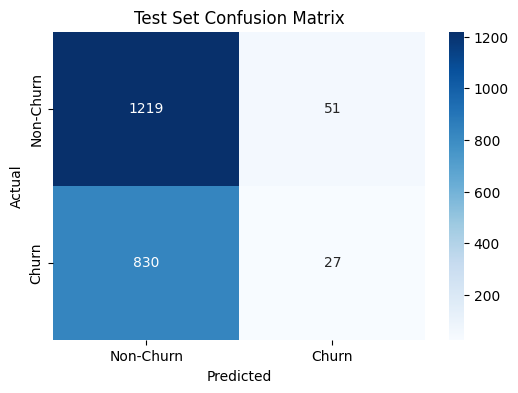

Accuracy: 0.5858015984955336
Precision: 0.34615384615384615
F1-Score: 0.057754010695187166
Sensitivity (Recall): 0.03150525087514586
Specificity: 0.9598425196850394


In [ ]:
# within sample creation
train, test = train_test_split(social_raider_lr, test_size=0.3,random_state=1)


# Model building
logit_mod = smf.logit(formula='churn ~ frequency+recency+monetary+Age+females+low_income+high_income+retention_rate+CLV+fallbonus+average_experience+average_social+average_pokemons+average_distance+average_duration+average_pokestops+average_gym+average_raids', data=train)

logit_res = logit_mod.fit()
print(logit_res.summary())

# Feature Importance (using coefficients)
feature_df = pd.DataFrame({
    'Feature': logit_res.params.index,
    'Coefficient': logit_res.params.values
})

# Calculate Importance as the absolute value of coefficients
feature_df['Importance'] = feature_df['Coefficient'].abs()
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Filter out the intercept before plotting
feature_df_filtered = feature_df[feature_df['Feature'] != 'Intercept']


# Plot Feature Importance with different colors for each feature
plt.figure(figsize=(10, 6))

# Use a color palette that assigns different colors to each bar
sns.barplot(x='Importance', y='Feature', data=feature_df_filtered, palette='magma')

plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

# Predict on train and test sets
train_predictions = logit_res.predict(train)
test_predictions = logit_res.predict(test)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
train_predictions_binary = (train_predictions >= 0.5).astype(int)
test_predictions_binary = (test_predictions >= 0.5).astype(int)

# --- Evaluation Metrics ---
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Train Set Evaluation ---
print("\n--- Train Set Evaluation ---")

# Confusion Matrix
train_conf_matrix = confusion_matrix(train['churn'], train_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Train Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
train_accuracy = accuracy_score(train['churn'], train_predictions_binary)
print("Accuracy:", train_accuracy)

# Precision
train_precision = precision_score(train['churn'], train_predictions_binary)
print("Precision:", train_precision)

# F1-Score
train_f1 = f1_score(train['churn'], train_predictions_binary)
print("F1-Score:", train_f1)


# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = train_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# --- Test Set Evaluation ---
print("\n--- Test Set Evaluation ---")

# Confusion Matrix
test_conf_matrix = confusion_matrix(test['churn'], test_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
test_accuracy = accuracy_score(test['churn'], test_predictions_binary)
print("Accuracy:", test_accuracy)

# Precision
test_precision = precision_score(test['churn'], test_predictions_binary)
print("Precision:", test_precision)

# F1-Score
test_f1 = f1_score(test['churn'], test_predictions_binary)
print("F1-Score:", test_f1)

# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = test_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)


Based on the logistic regression output for the Social Raiders segment, the significant predictors of churn are fall bonus, average experience, average social, average Pokémon, average distance, average PokéStops, average gym, and average raids. Therefore, we will include only these variables in our final model to improve accuracy.

**Social raiders final model**

Optimization terminated successfully.
         Current function value: 0.662665
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 4963
Model:                          Logit   Df Residuals:                     4954
Method:                           MLE   Df Model:                            8
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                 0.01390
Time:                        18:50:31   Log-Likelihood:                -3288.8
converged:                       True   LL-Null:                       -3335.1
Covariance Type:            nonrobust   LLR p-value:                 1.323e-16
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.2620      0.267     -0.979      0.327      -0.786       0.262
fallb

<ipython-input-51-c0cd90ba86c7>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



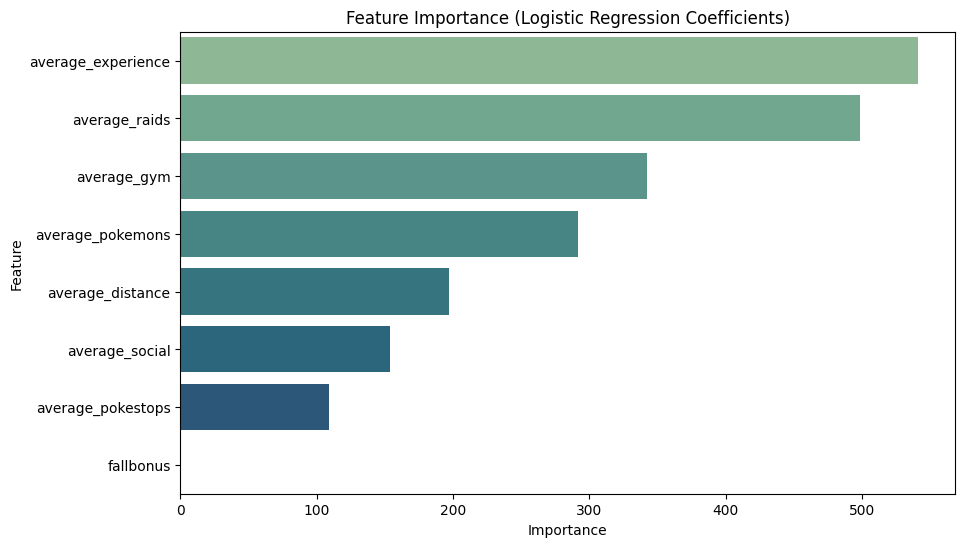


--- Train Set Evaluation ---


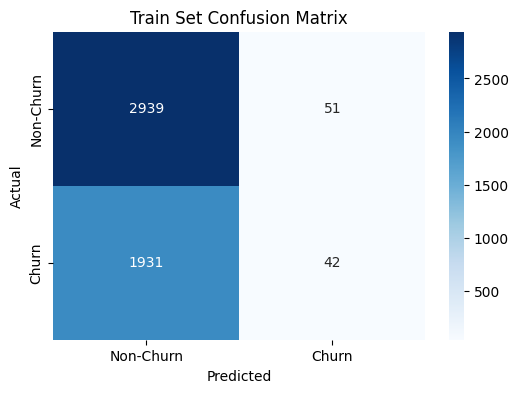

Accuracy: 0.6006447713076768
Precision: 0.45161290322580644
F1-Score: 0.04065827686350436
Sensitivity (Recall): 0.021287379624936646
Specificity: 0.982943143812709

--- Test Set Evaluation ---


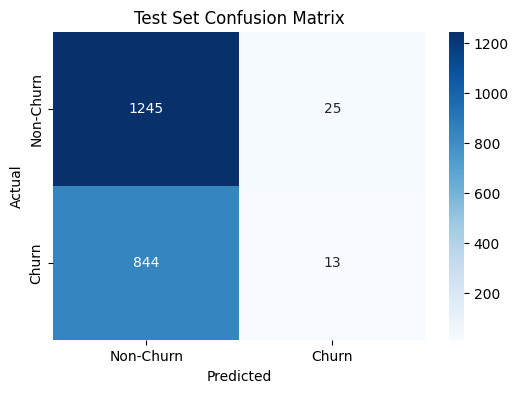

Accuracy: 0.5914433474377057
Precision: 0.34210526315789475
F1-Score: 0.02905027932960894
Sensitivity (Recall): 0.015169194865810968
Specificity: 0.9803149606299213


In [ ]:
# within sample creation
train, test = train_test_split(social_raider_lr, test_size=0.3,random_state=1)

# Model building
logit_mod = smf.logit(formula='churn ~ fallbonus+average_experience+average_social+average_pokemons+average_distance+average_pokestops+average_gym+average_raids', data=train)

logit_res = logit_mod.fit()
print(logit_res.summary())

# Feature Importance (using coefficients)
feature_df = pd.DataFrame({
    'Feature': logit_res.params.index,
    'Coefficient': logit_res.params.values
})

# Calculate Importance as the absolute value of coefficients
feature_df['Importance'] = feature_df['Coefficient'].abs()
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Filter out the intercept before plotting
feature_df_filtered = feature_df[feature_df['Feature'] != 'Intercept']


# Plot Feature Importance with different colors for each feature
plt.figure(figsize=(10, 6))

# Use a color palette that assigns different colors to each bar
sns.barplot(x='Importance', y='Feature', data=feature_df_filtered, palette='crest')

plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

# Predict on train and test sets
train_predictions = logit_res.predict(train)
test_predictions = logit_res.predict(test)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
train_predictions_binary = (train_predictions >= 0.5).astype(int)
test_predictions_binary = (test_predictions >= 0.5).astype(int)

# --- Evaluation Metrics ---
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Train Set Evaluation ---
print("\n--- Train Set Evaluation ---")

# Confusion Matrix
train_conf_matrix = confusion_matrix(train['churn'], train_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Train Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
train_accuracy = accuracy_score(train['churn'], train_predictions_binary)
print("Accuracy:", train_accuracy)

# Precision
train_precision = precision_score(train['churn'], train_predictions_binary)
print("Precision:", train_precision)

# F1-Score
train_f1 = f1_score(train['churn'], train_predictions_binary)
print("F1-Score:", train_f1)


# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = train_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# --- Test Set Evaluation ---
print("\n--- Test Set Evaluation ---")

# Confusion Matrix
test_conf_matrix = confusion_matrix(test['churn'], test_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
test_accuracy = accuracy_score(test['churn'], test_predictions_binary)
print("Accuracy:", test_accuracy)

# Precision
test_precision = precision_score(test['churn'], test_predictions_binary)
print("Precision:", test_precision)

# F1-Score
test_f1 = f1_score(test['churn'], test_predictions_binary)
print("F1-Score:", test_f1)

# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = test_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)


### **Catchers**

Optimization terminated successfully.
         Current function value: 0.508381
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 2913
Model:                          Logit   Df Residuals:                     2894
Method:                           MLE   Df Model:                           18
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                 0.01196
Time:                        18:50:32   Log-Likelihood:                -1480.9
converged:                       True   LL-Null:                       -1498.8
Covariance Type:            nonrobust   LLR p-value:                  0.007387
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.7829      1.316      0.595      0.552      -1.795       3.361
freq

<ipython-input-52-2be5a0c544f9>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



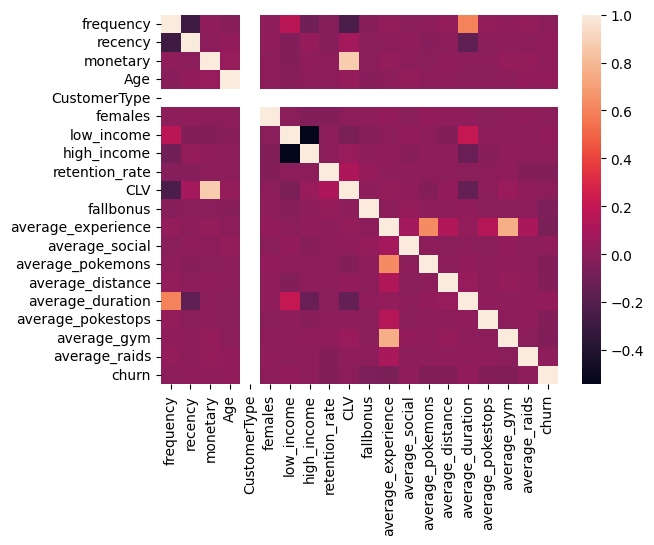

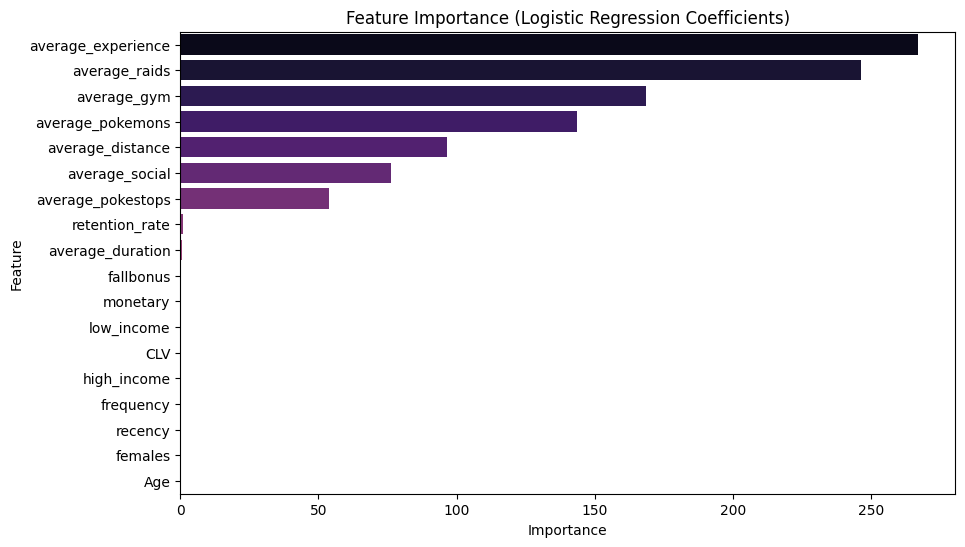


--- Train Set Evaluation ---


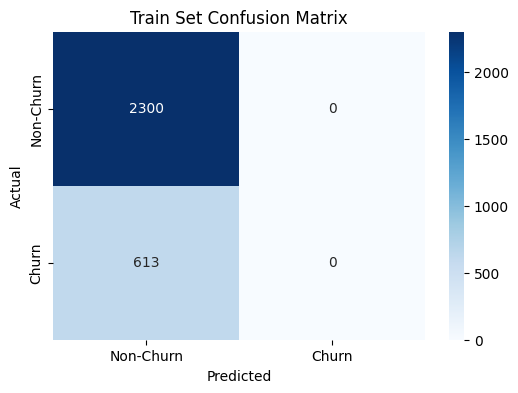

Accuracy: 0.789564023343632
Precision: 0.0
F1-Score: 0.0
Sensitivity (Recall): 0.0
Specificity: 1.0

--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


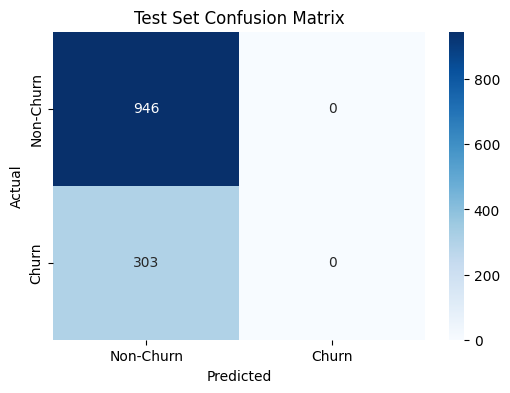

Accuracy: 0.7574059247397918
Precision: 0.0
F1-Score: 0.0
Sensitivity (Recall): 0.0
Specificity: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
# within sample creation
train, test = train_test_split(catcher_lr, test_size=0.3,random_state=1)
# Exploratory analysis
corrmatrixtrain=train.corr()
sns.heatmap(train.corr())

# Model building
logit_mod = smf.logit(formula='churn ~ frequency+recency+monetary+Age+females+low_income+high_income+retention_rate+CLV+fallbonus+average_experience+average_social+average_pokemons+average_distance+average_duration+average_pokestops+average_gym+average_raids', data=train)

logit_res = logit_mod.fit()
print(logit_res.summary())

# Feature Importance (using coefficients)
feature_df = pd.DataFrame({
    'Feature': logit_res.params.index,
    'Coefficient': logit_res.params.values
})

# Calculate Importance as the absolute value of coefficients
feature_df['Importance'] = feature_df['Coefficient'].abs()
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Filter out the intercept before plotting
feature_df_filtered = feature_df[feature_df['Feature'] != 'Intercept']


# Plot Feature Importance with different colors for each feature
plt.figure(figsize=(10, 6))

# Use a color palette that assigns different colors to each bar
sns.barplot(x='Importance', y='Feature', data=feature_df_filtered, palette='magma')

plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

# Predict on train and test sets
train_predictions = logit_res.predict(train)
test_predictions = logit_res.predict(test)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
train_predictions_binary = (train_predictions >= 0.5).astype(int)
test_predictions_binary = (test_predictions >= 0.5).astype(int)

# --- Evaluation Metrics ---
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Train Set Evaluation ---
print("\n--- Train Set Evaluation ---")

# Confusion Matrix
train_conf_matrix = confusion_matrix(train['churn'], train_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Train Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
train_accuracy = accuracy_score(train['churn'], train_predictions_binary)
print("Accuracy:", train_accuracy)

# Precision
train_precision = precision_score(train['churn'], train_predictions_binary)
print("Precision:", train_precision)

# F1-Score
train_f1 = f1_score(train['churn'], train_predictions_binary)
print("F1-Score:", train_f1)


# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = train_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# --- Test Set Evaluation ---
print("\n--- Test Set Evaluation ---")

# Confusion Matrix
test_conf_matrix = confusion_matrix(test['churn'], test_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
test_accuracy = accuracy_score(test['churn'], test_predictions_binary)
print("Accuracy:", test_accuracy)

# Precision
test_precision = precision_score(test['churn'], test_predictions_binary)
print("Precision:", test_precision)

# F1-Score
test_f1 = f1_score(test['churn'], test_predictions_binary)
print("F1-Score:", test_f1)

# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = test_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)


Based on the logistic regression output for the Catchers segment, fall bonus is the only significant predictor of churn. However, given the definition of this segment, we assume that average Pokémon and average PokéStops may also be useful in predicting churn behavior. Therefore, we will include these variables in our final model to improve accuracy and gain deeper insights.

**Catchers final model**

Optimization terminated successfully.
         Current function value: 0.511733
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 2913
Model:                          Logit   Df Residuals:                     2909
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                0.005444
Time:                        18:50:33   Log-Likelihood:                -1490.7
converged:                       True   LL-Null:                       -1498.8
Covariance Type:            nonrobust   LLR p-value:                 0.0009750
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.6891      0.214     -3.221      0.001      -1.108      -0.270
average_

<ipython-input-53-d5e806411874>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



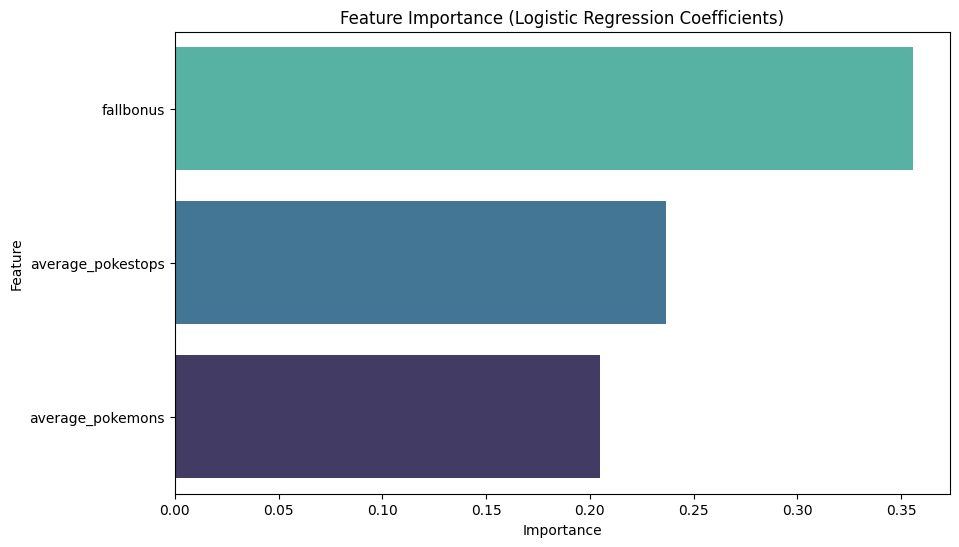


--- Train Set Evaluation ---


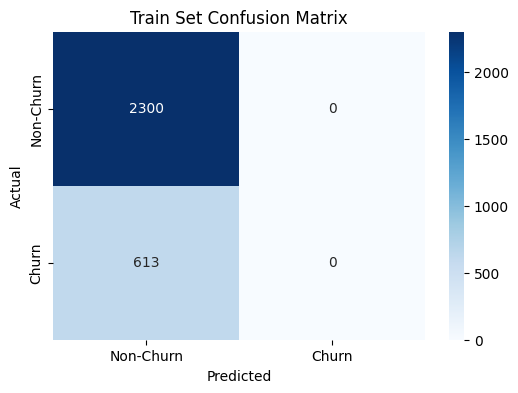

Accuracy: 0.789564023343632
Precision: 0.0
F1-Score: 0.0
Sensitivity (Recall): 0.0
Specificity: 1.0

--- Test Set Evaluation ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


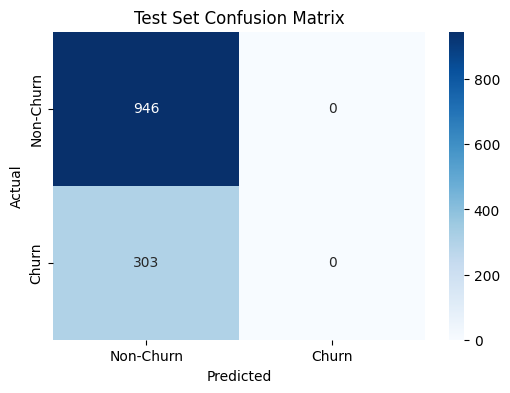

Accuracy: 0.7574059247397918
Precision: 0.0
F1-Score: 0.0
Sensitivity (Recall): 0.0
Specificity: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
# within sample creation
train, test = train_test_split(catcher_lr, test_size=0.3,random_state=1)


# Model building
logit_mod = smf.logit(formula='churn ~ average_pokemons+average_pokestops+fallbonus', data=train)

logit_res = logit_mod.fit()
print(logit_res.summary())

# Feature Importance (using coefficients)
feature_df = pd.DataFrame({
    'Feature': logit_res.params.index,
    'Coefficient': logit_res.params.values
})

# Calculate Importance as the absolute value of coefficients
feature_df['Importance'] = feature_df['Coefficient'].abs()
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Filter out the intercept before plotting
feature_df_filtered = feature_df[feature_df['Feature'] != 'Intercept']


# Plot Feature Importance with different colors for each feature
plt.figure(figsize=(10, 6))

# Use a color palette that assigns different colors to each bar
sns.barplot(x='Importance', y='Feature', data=feature_df_filtered, palette='mako_r')

plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

# Predict on train and test sets
train_predictions = logit_res.predict(train)
test_predictions = logit_res.predict(test)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
train_predictions_binary = (train_predictions >= 0.5).astype(int)
test_predictions_binary = (test_predictions >= 0.5).astype(int)

# --- Evaluation Metrics ---
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Train Set Evaluation ---
print("\n--- Train Set Evaluation ---")

# Confusion Matrix
train_conf_matrix = confusion_matrix(train['churn'], train_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Train Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
train_accuracy = accuracy_score(train['churn'], train_predictions_binary)
print("Accuracy:", train_accuracy)

# Precision
train_precision = precision_score(train['churn'], train_predictions_binary)
print("Precision:", train_precision)

# F1-Score
train_f1 = f1_score(train['churn'], train_predictions_binary)
print("F1-Score:", train_f1)


# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = train_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

# --- Test Set Evaluation ---
print("\n--- Test Set Evaluation ---")

# Confusion Matrix
test_conf_matrix = confusion_matrix(test['churn'], test_predictions_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
test_accuracy = accuracy_score(test['churn'], test_predictions_binary)
print("Accuracy:", test_accuracy)

# Precision
test_precision = precision_score(test['churn'], test_predictions_binary)
print("Precision:", test_precision)

# F1-Score
test_f1 = f1_score(test['churn'], test_predictions_binary)
print("F1-Score:", test_f1)

# Calculate Sensitivity (Recall) and Specificity
TN, FP, FN, TP = test_conf_matrix.ravel()  # Extract values from confusion matrix
sensitivity = TP / (TP + FN)  # Sensitivity = Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

In [ ]:
# Balanced dataset function
#is this a balanced dataset?
print('percentage churn in train dataset: ',np.round(np.mean(train['churn'])*100,2))
print('percentage churn in test dataset: ',np.round(np.mean(test['churn'])*100,2))

percentage churn in train dataset:  21.04
percentage churn in test dataset:  24.26
